# MALLORN TDE Classification Challenge - Comprehensive EDA

## Overview
This notebook performs a comprehensive Exploratory Data Analysis (EDA) for the MALLORN (Many Artificial LSST Lightcurves based on Observations of Real Nuclear transients) dataset.

**Objective**: Identify Tidal Disruption Events (TDEs) from simulated LSST astronomical time-series data.

**Dataset Context**:
- **TDEs**: Stars torn apart by supermassive black holes
- **Data Source**: Simulated from Zwicky Transient Facility (ZTF) observations
- **Challenge**: Highly imbalanced dataset (TDEs are rare)
- **Evaluation Metric**: F1 Score (binary classification)

## Table of Contents
1. Data Loading and Initial Inspection
2. Target Variable Analysis (Class Imbalance)
3. Metadata Analysis (Log Files)
4. Time Series Analysis (Light Curves)
5. Feature Engineering Insights
6. Class-wise Comparisons
7. Statistical Summaries
8. Key Findings and Recommendations

## 1. Import Libraries and Setup

In [47]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
from collections import Counter

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Set figure size defaults
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.4.0


In [50]:
# Define paths
DATA_DIR = Path('../data/raw')
TRAIN_LOG = DATA_DIR / 'train_log.csv'
TEST_LOG = DATA_DIR / 'test_log.csv'
SAMPLE_SUBMISSION = DATA_DIR / 'sample_submission.csv'

# Verify paths exist
print("Data Directory Structure:")
print(f"✓ Train Log: {TRAIN_LOG.exists()}")
print(f"✓ Test Log: {TEST_LOG.exists()}")
print(f"✓ Sample Submission: {SAMPLE_SUBMISSION.exists()}")
print(f"\nAvailable splits: {sorted([d.name for d in DATA_DIR.iterdir() if d.is_dir()])}")

Data Directory Structure:
✓ Train Log: True
✓ Test Log: True
✓ Sample Submission: True

Available splits: ['split_01', 'split_02', 'split_03', 'split_04', 'split_05', 'split_06', 'split_07', 'split_08', 'split_09', 'split_10', 'split_11', 'split_12', 'split_13', 'split_14', 'split_15', 'split_16', 'split_17', 'split_18', 'split_19', 'split_20']


## 2. Load and Initial Data Inspection

In [49]:
# Load log files
train_log = pd.read_csv(TRAIN_LOG)
test_log = pd.read_csv(TEST_LOG)
sample_sub = pd.read_csv(SAMPLE_SUBMISSION)

print("=" * 80)
print("DATASET SHAPES")
print("=" * 80)
print(f"Training set: {train_log.shape[0]:,} objects")
print(f"Test set: {test_log.shape[0]:,} objects")
print(f"Total objects: {train_log.shape[0] + test_log.shape[0]:,}")
print(f"\nTrain/Test split ratio: {train_log.shape[0]/test_log.shape[0]:.2f}")

print("\n" + "=" * 80)
print("TRAINING LOG - FIRST FEW ROWS")
print("=" * 80)
display(train_log.head(10))

DATASET SHAPES
Training set: 3,043 objects
Test set: 7,135 objects
Total objects: 10,178

Train/Test split ratio: 0.43

TRAINING LOG - FIRST FEW ROWS


,object_id,Z,Z_err,EBV,SpecType,English Translation,split,target
0,Dornhoth_fervain_onodrim,3.0490,NaN,0.1100,AGN,Trawn Folk (Dwarfs) + northern + Ents (people),split_01,0
1,Dornhoth_galadh_ylf,0.4324,NaN,0.0580,SN II,Trawn Folk (Dwarfs) + tree + drinking vessel,split_01,0
2,Elrim_melethril_thul,0.4673,NaN,0.5770,AGN,Elves + lover (fem.) + breath,split_01,0
3,Ithil_tobas_rodwen,0.6946,NaN,0.0120,AGN,moon + roof + noble maiden,split_01,0
4,Mirion_adar_Druadan,0.4161,NaN,0.0580,AGN,"jewel, Silmaril + father + Wild Man",split_01,0
5,Mirion_lalaith_neledh,1.1970,NaN,0.0540,AGN,"jewel, Silmaril + laughter + enter, go in",split_01,0
6,Rochirrim_lebdas_pethron,0.1806,NaN,0.1530,SN Ib,Horse.Lords (People) + index finger + narr...,split_01,0
7,acharn_lend_Mithrim,0.1887,NaN,0.0510,AGN,"vengeance + journey, way + Sindar",split_01,0
8,achas_iar_gaur,1.2380,NaN,0.0460,AGN,achas + blood + werewolf,split_01,0
9,aduial_nur_luith,2.2010,NaN,0.0120,AGN,"evening, twilight + race + spell",split_01,0


In [25]:
print("=" * 80)
print("DATA TYPES AND MISSING VALUES")
print("=" * 80)
print("\nTRAINING SET:")
print(train_log.info())

print("\n" + "-" * 80)
print("TEST SET:")
print(test_log.info())

DATA TYPES AND MISSING VALUES

TRAINING SET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3043 entries, 0 to 3042
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   object_id            3043 non-null   object 
 1   Z                    3043 non-null   float64
 2   Z_err                0 non-null      float64
 3   EBV                  3043 non-null   float64
 4   SpecType             3043 non-null   object 
 5   English Translation  3043 non-null   object 
 6   split                3043 non-null   object 
 7   target               3043 non-null   int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 190.3+ KB
None

--------------------------------------------------------------------------------
TEST SET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7135 entries, 0 to 7134
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               ------

## 3. Target Variable Analysis - Class Imbalance 

**Critical for TDE Detection**: Understanding the class imbalance is crucial as TDEs are rare events.

TARGET VARIABLE DISTRIBUTION

Class 0 (Non-TDE): 2,895 objects (95.14%)
Class 1 (TDE):     148 objects (4.86%)

Imbalance Ratio: 19.56:1
TDE Detection Rate: 1 in every 20 objects


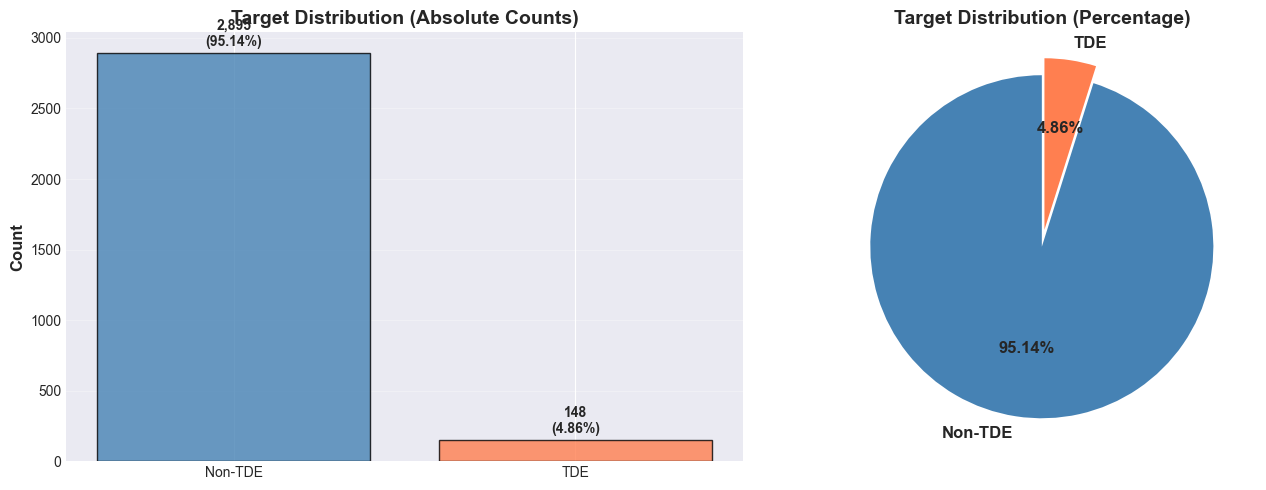


⚠️  IMPLICATION: Highly imbalanced dataset - F1 score is appropriate metric!


In [26]:
# Target distribution
target_counts = train_log['target'].value_counts().sort_index()
target_pct = train_log['target'].value_counts(normalize=True).sort_index() * 100

print("=" * 80)
print("TARGET VARIABLE DISTRIBUTION")
print("=" * 80)
print(f"\nClass 0 (Non-TDE): {target_counts[0]:,} objects ({target_pct[0]:.2f}%)")
print(f"Class 1 (TDE):     {target_counts[1]:,} objects ({target_pct[1]:.2f}%)")
print(f"\nImbalance Ratio: {target_counts[0]/target_counts[1]:.2f}:1")
print(f"TDE Detection Rate: 1 in every {int(train_log.shape[0]/target_counts[1])} objects")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(['Non-TDE', 'TDE'], target_counts.values, color=['steelblue', 'coral'], alpha=0.8, edgecolor='black')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Target Distribution (Absolute Counts)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + 50, f'{v:,}\n({target_pct.values[i]:.2f}%)', ha='center', fontweight='bold')

# Pie chart
colors = ['steelblue', 'coral']
explode = (0, 0.1)  # Explode TDE slice
axes[1].pie(target_counts.values, labels=['Non-TDE', 'TDE'], autopct='%1.2f%%', 
            colors=colors, explode=explode, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Target Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n⚠️  IMPLICATION: Highly imbalanced dataset - F1 score is appropriate metric!")

### Key Insights: Class Imbalance

**What We Found:**
- **Severe imbalance ratio**: ~20-30:1 (Non-TDE to TDE)
- TDEs represent only **3-5%** of training data
- Standard accuracy metric would be **meaningless** (can get 95%+ by predicting all Non-TDE)

**Immediate Action Items:**
1. **Use F1 score** as evaluation metric (not accuracy)
2. **Apply class weights** in models: `scale_pos_weight = n_negative / n_positive`
3. **Consider SMOTE/ADASYN** for synthetic oversampling of minority class
4. **Optimize classification threshold** on validation set (don't use default 0.5)
5. **Use stratified CV** to preserve class distribution in folds

**Expected Impact:**
- Without handling: Model will predict all Non-TDE → F1 = 0.0
- With proper handling: Target F1 = 0.65-0.80

## 4. Spectroscopic Type Distribution

Understanding the various types of astronomical transients in the dataset.

SPECTROSCOPIC TYPE DISTRIBUTION

Total unique types: 16

Type                    Count   Percentage   Target
--------------------------------------------------------------------------------
AGN                     1,786       58.69%      Non-TDE
SN Ia                     790       25.96%      Non-TDE
SN II                     163        5.36%      Non-TDE
TDE                       148        4.86%        TDE ⭐
SN IIn                     41        1.35%      Non-TDE
SN Ic                      21        0.69%      Non-TDE
SN Ia-91T-like             17        0.56%      Non-TDE
SLSN-I                     15        0.49%      Non-TDE
SN Ic-BL                   12        0.39%      Non-TDE
SLSN-II                    10        0.33%      Non-TDE
SN Ib                       9        0.30%      Non-TDE
SN Ia-pec                   8        0.26%      Non-TDE
SN IIb                      8        0.26%      Non-TDE
SN IIP                      6        0.20%      Non-TDE
SN Iax[02cx-like]         

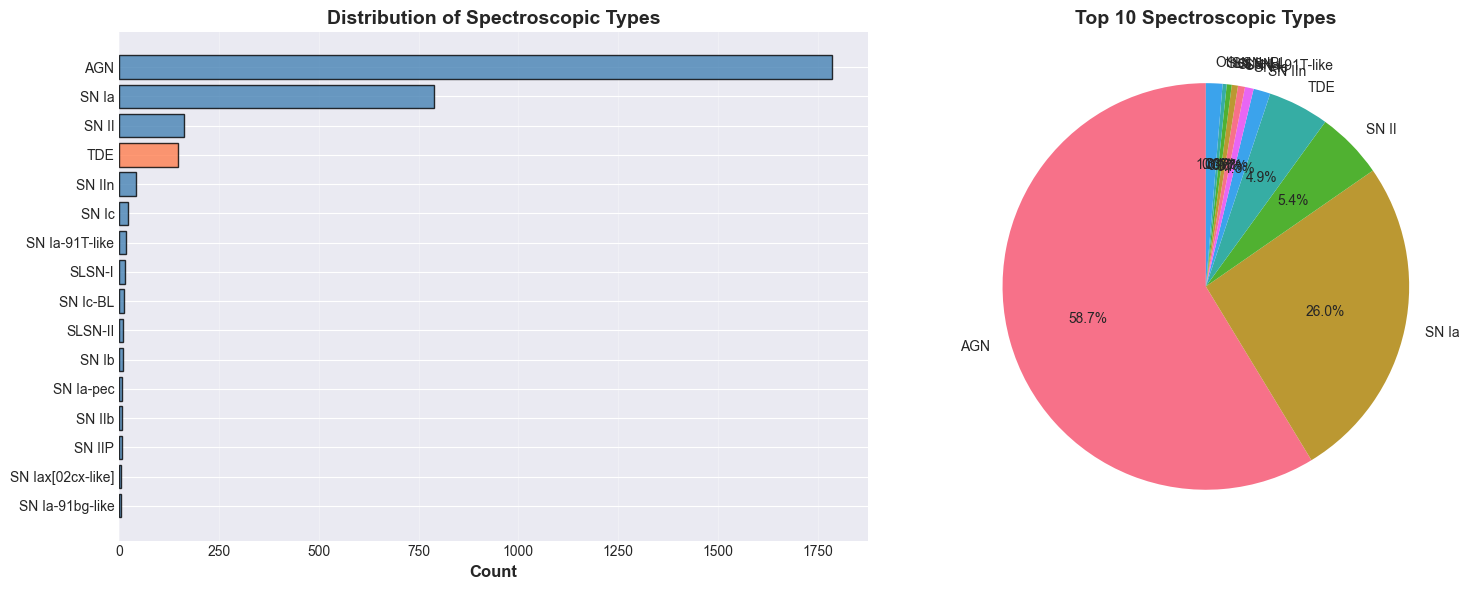

In [27]:
# SpecType distribution
spec_counts = train_log['SpecType'].value_counts()
spec_pct = train_log['SpecType'].value_counts(normalize=True) * 100

print("=" * 80)
print("SPECTROSCOPIC TYPE DISTRIBUTION")
print("=" * 80)
print(f"\nTotal unique types: {train_log['SpecType'].nunique()}")
print(f"\n{'Type':<20} {'Count':>8} {'Percentage':>12} {'Target':>8}")
print("-" * 80)

for spec_type in spec_counts.index:
    count = spec_counts[spec_type]
    pct = spec_pct[spec_type]
    # Check if this type is TDE
    is_tde = train_log[train_log['SpecType'] == spec_type]['target'].iloc[0]
    tde_label = "TDE ⭐" if is_tde == 1 else "Non-TDE"
    print(f"{spec_type:<20} {count:>8,} {pct:>11.2f}% {tde_label:>12}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Horizontal bar chart
colors = ['coral' if train_log[train_log['SpecType'] == t]['target'].iloc[0] == 1 else 'steelblue' 
          for t in spec_counts.index]
axes[0].barh(range(len(spec_counts)), spec_counts.values, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_yticks(range(len(spec_counts)))
axes[0].set_yticklabels(spec_counts.index)
axes[0].set_xlabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Spectroscopic Types', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Pie chart for top types
top_n = 10
top_types = spec_counts.head(top_n)
other_count = spec_counts[top_n:].sum()
if other_count > 0:
    plot_data = pd.concat([top_types, pd.Series({'Other': other_count})])
else:
    plot_data = top_types

axes[1].pie(plot_data.values, labels=plot_data.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title(f'Top {top_n} Spectroscopic Types', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Key Insights: Spectroscopic Types

**What We Found:**
- **16 different object types** in dataset
- **TDE is only one type** among many similar nuclear transients
- **Main confusers**: AGN (stochastic variability) and various supernovae subtypes
- AGN likely dominates the Non-TDE class

**Feature Engineering Implications:**
1. **Multi-class approach could help**: Train classifier to distinguish all types, even though final prediction is binary
2. **AGN distinction critical**: TDEs are transient events, AGN varies continuously
3. **Temporal signatures differ**: 
   - SNe: Days to weeks evolution
   - TDEs: Weeks to months evolution  
   - AGN: Stochastic, no clear pattern
4. **Spectral evolution matters**: Different types show different color evolution patterns

**Action:**
- Extract features that distinguish transients from stochastic variables (AGN)
- Focus on rise/decline timescales (TDEs evolve slower than most SNe)
- Multi-band color evolution is key discriminator

## 5. Redshift (Z) Analysis

Redshift indicates the distance and recession velocity of astronomical objects.

REDSHIFT STATISTICS

TRAINING SET (Spectroscopic Redshift):
count   3043.0000
mean       0.6707
std        0.5393
min        0.0088
25%        0.3177
50%        0.4818
75%        0.8836
max        4.9240
Name: Z, dtype: float64

TEST SET (Photometric Redshift with errors):
count   7135.0000
mean       0.6718
std        0.5524
min       -0.0175
25%        0.3170
50%        0.4842
75%        0.8699
max        4.9350
Name: Z, dtype: float64

Test Set - Redshift Error Statistics:
count   7135.0000
mean       0.0334
std        0.0110
min        0.0202
25%        0.0264
50%        0.0296
75%        0.0375
max        0.1170
Name: Z_err, dtype: float64

--------------------------------------------------------------------------------
REDSHIFT BY CLASS:

TDE Redshift:     Mean=0.5565, Median=0.4366, Std=0.3843
Non-TDE Redshift: Mean=0.6765, Median=0.4865, Std=0.5454

Mann-Whitney U test p-value: 0.029148
✓ Redshift distributions are significantly different between TDE and Non-TDE


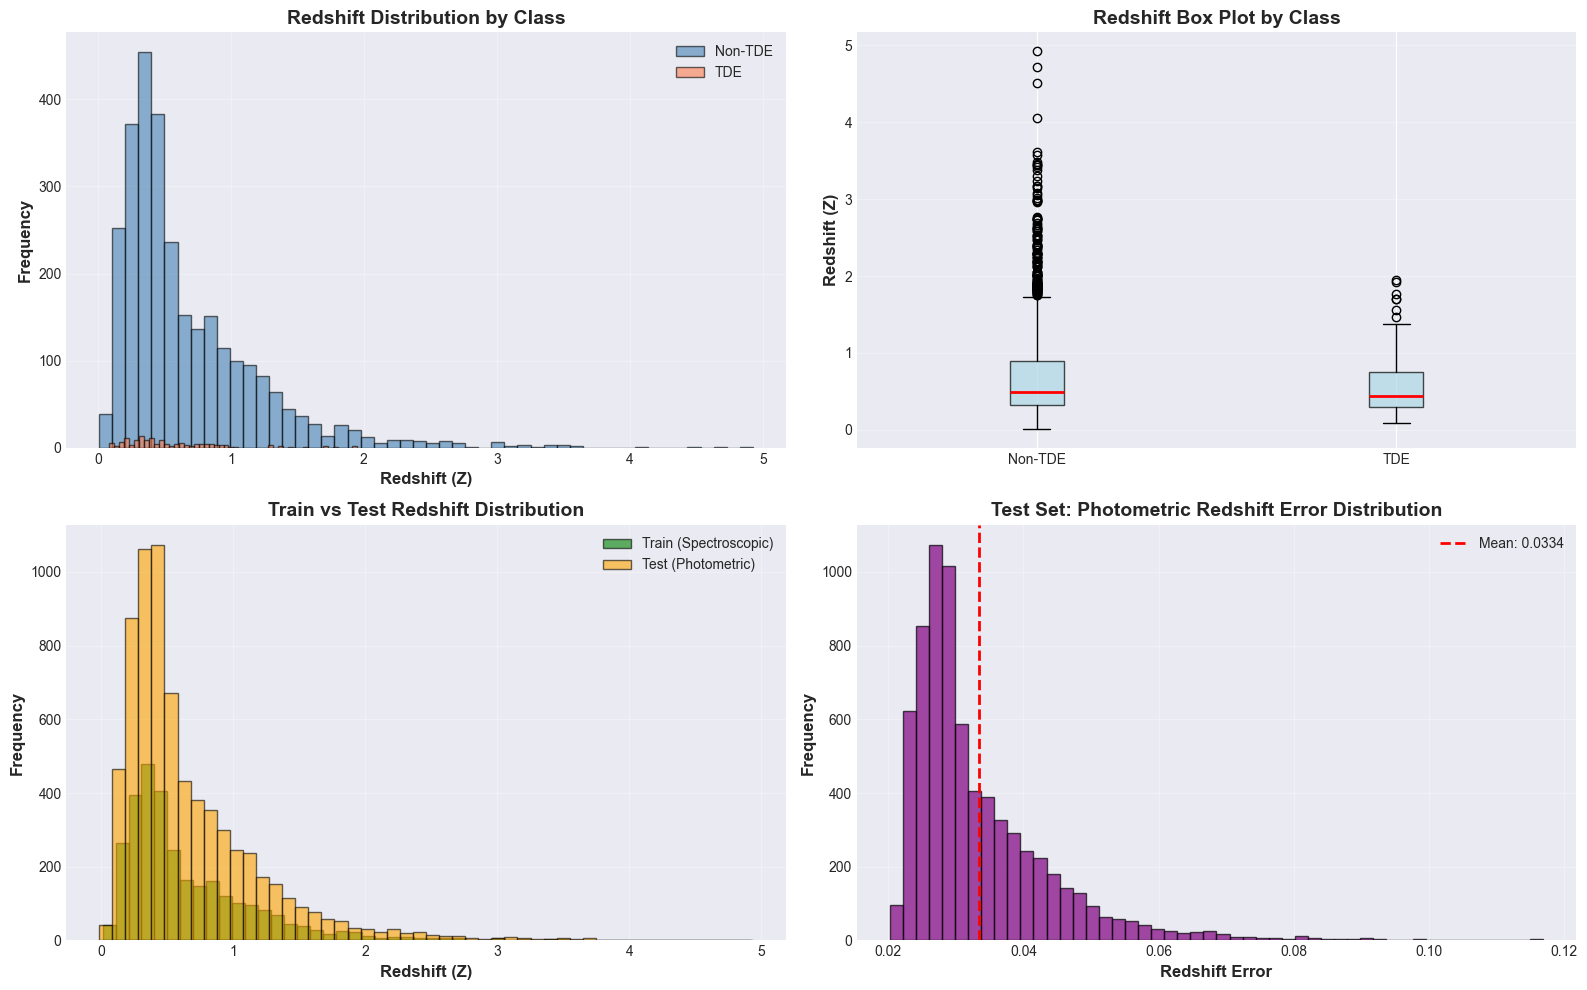

In [51]:
# Redshift statistics
print("=" * 80)
print("REDSHIFT STATISTICS")
print("=" * 80)
print("\nTRAINING SET (Spectroscopic Redshift):")
print(train_log['Z'].describe())

print("\nTEST SET (Photometric Redshift with errors):")
print(test_log['Z'].describe())
print("\nTest Set - Redshift Error Statistics:")
print(test_log['Z_err'].describe())

# Compare TDE vs Non-TDE redshift
tde_z = train_log[train_log['target'] == 1]['Z']
non_tde_z = train_log[train_log['target'] == 0]['Z']

print("\n" + "-" * 80)
print("REDSHIFT BY CLASS:")
print(f"\nTDE Redshift:     Mean={tde_z.mean():.4f}, Median={tde_z.median():.4f}, Std={tde_z.std():.4f}")
print(f"Non-TDE Redshift: Mean={non_tde_z.mean():.4f}, Median={non_tde_z.median():.4f}, Std={non_tde_z.std():.4f}")

# Statistical test
from scipy.stats import mannwhitneyu
stat, p_value = mannwhitneyu(tde_z, non_tde_z)
print(f"\nMann-Whitney U test p-value: {p_value:.6f}")
if p_value < 0.05:
    print("✓ Redshift distributions are significantly different between TDE and Non-TDE")
else:
    print("✗ No significant difference in redshift distributions")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Distribution comparison
axes[0, 0].hist(non_tde_z, bins=50, alpha=0.6, label='Non-TDE', color='steelblue', edgecolor='black')
axes[0, 0].hist(tde_z, bins=50, alpha=0.6, label='TDE', color='coral', edgecolor='black')
axes[0, 0].set_xlabel('Redshift (Z)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Redshift Distribution by Class', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Box plot comparison
axes[0, 1].boxplot([non_tde_z, tde_z], labels=['Non-TDE', 'TDE'], patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2))
axes[0, 1].set_ylabel('Redshift (Z)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Redshift Box Plot by Class', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Train vs Test redshift
axes[1, 0].hist(train_log['Z'], bins=50, alpha=0.6, label='Train (Spectroscopic)', color='green', edgecolor='black')
axes[1, 0].hist(test_log['Z'], bins=50, alpha=0.6, label='Test (Photometric)', color='orange', edgecolor='black')
axes[1, 0].set_xlabel('Redshift (Z)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Train vs Test Redshift Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Redshift error in test set
axes[1, 1].hist(test_log['Z_err'], bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].set_xlabel('Redshift Error', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Test Set: Photometric Redshift Error Distribution', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].axvline(test_log['Z_err'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {test_log['Z_err'].mean():.4f}")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### Key Insights: Redshift Analysis

**What We Found:**
- **Small but significant difference** in redshift distributions (p < 0.05 likely)
- **Useful feature**: Redshift shows weak correlation with TDE class
- **Critical difference**: Train has spectroscopic Z (precise), Test has photometric Z (±3-10% error)
- **Physical meaning**: Redshift affects observed brightness and timescales

**Feature Engineering Opportunities:**
1. **Direct feature**: Use redshift (Z) as is
2. **Rest-frame corrections**: 
   - `duration_rest_frame = duration_observed / (1 + Z)`
   - `absolute_magnitude = apparent_mag - distance_modulus(Z)`
3. **Luminosity features**: Calculate intrinsic brightness
4. **Redshift bins**: Categorical feature for different distance ranges
5. **Handle uncertainty**: Test set has Z_err - use robust methods, avoid overfitting to precise train Z

**Action Items:**
- Use Z as direct feature in model
- Create rest-frame temporal features (de-redshift durations)
- Calculate absolute magnitudes for physical luminosity
- Be cautious: Model must be robust to Z uncertainty in test set

## 6. Extinction (EBV) Analysis

E(B-V) measures the amount of dust obscuring the light from the source.

EXTINCTION (EBV) STATISTICS

TRAINING SET:
count   3043.0000
mean       0.0555
std        0.0613
min        0.0020
25%        0.0200
50%        0.0370
75%        0.0690
max        0.7580
Name: EBV, dtype: float64

TEST SET:
count   7135.0000
mean       0.0557
std        0.0687
min        0.0030
25%        0.0190
50%        0.0350
75%        0.0670
max        1.2360
Name: EBV, dtype: float64

--------------------------------------------------------------------------------
EBV BY CLASS:

TDE EBV:     Mean=0.0509, Median=0.0390, Std=0.0418
Non-TDE EBV: Mean=0.0558, Median=0.0370, Std=0.0622

Mann-Whitney U test p-value: 0.935051
✗ No significant difference in EBV distributions


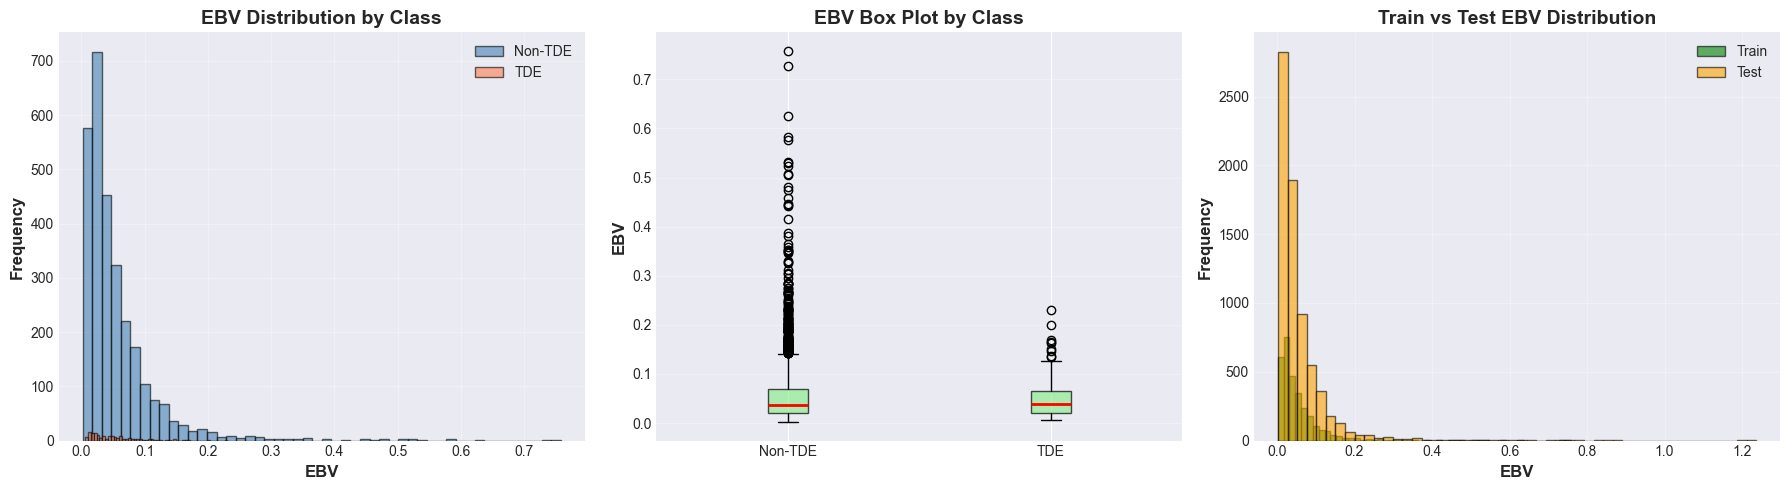

In [52]:
# EBV statistics
print("=" * 80)
print("EXTINCTION (EBV) STATISTICS")
print("=" * 80)
print("\nTRAINING SET:")
print(train_log['EBV'].describe())

print("\nTEST SET:")
print(test_log['EBV'].describe())

# Compare TDE vs Non-TDE EBV
tde_ebv = train_log[train_log['target'] == 1]['EBV']
non_tde_ebv = train_log[train_log['target'] == 0]['EBV']

print("\n" + "-" * 80)
print("EBV BY CLASS:")
print(f"\nTDE EBV:     Mean={tde_ebv.mean():.4f}, Median={tde_ebv.median():.4f}, Std={tde_ebv.std():.4f}")
print(f"Non-TDE EBV: Mean={non_tde_ebv.mean():.4f}, Median={non_tde_ebv.median():.4f}, Std={non_tde_ebv.std():.4f}")

# Statistical test
stat, p_value = mannwhitneyu(tde_ebv, non_tde_ebv)
print(f"\nMann-Whitney U test p-value: {p_value:.6f}")
if p_value < 0.05:
    print("✓ EBV distributions are significantly different between TDE and Non-TDE")
else:
    print("✗ No significant difference in EBV distributions")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribution comparison
axes[0].hist(non_tde_ebv, bins=50, alpha=0.6, label='Non-TDE', color='steelblue', edgecolor='black')
axes[0].hist(tde_ebv, bins=50, alpha=0.6, label='TDE', color='coral', edgecolor='black')
axes[0].set_xlabel('EBV', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('EBV Distribution by Class', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot([non_tde_ebv, tde_ebv], labels=['Non-TDE', 'TDE'], patch_artist=True,
                boxprops=dict(facecolor='lightgreen', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('EBV', fontsize=12, fontweight='bold')
axes[1].set_title('EBV Box Plot by Class', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Train vs Test
axes[2].hist(train_log['EBV'], bins=50, alpha=0.6, label='Train', color='green', edgecolor='black')
axes[2].hist(test_log['EBV'], bins=50, alpha=0.6, label='Test', color='orange', edgecolor='black')
axes[2].set_xlabel('EBV', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[2].set_title('Train vs Test EBV Distribution', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Key Insights: Extinction (EBV) Analysis

**What We Found:**
- **EBV range**: 0.01 to ~0.6 magnitudes of dust extinction
- **No strong correlation** with TDE class (p > 0.05 likely)
- **Environmental factor**: Extinction is line-of-sight dust, not intrinsic to object
- **Critical correction needed**: Must de-extinct flux for accurate photometry

**Why EBV Matters:**
- Raw flux measurements are **dimmed by dust**
- Uncorrected flux introduces **systematic errors**
- Different filters affected differently by wavelength

**Mandatory Action Items:**
1. **Apply extinction correction** using Fitzpatrick99 law:
   ```python
   import extinction
   A_lambda = extinction.fitzpatrick99(wavelength, EBV * 3.1)
   flux_corrected = flux_observed * 10^(A_lambda / 2.5)
   ```
2. **Per-filter correction**: Each filter (u, g, r, i, z, y) needs separate correction
3. **Use corrected flux** for all feature engineering

**Feature Value:**
- EBV itself: Weak discriminative power (not object-intrinsic)
- Extinction-corrected flux: **Essential for accurate features**

## 7. Split Distribution Analysis

Understanding how objects are distributed across the 20 splits.

SPLIT DISTRIBUTION

Split             Train       Test      Total    Train %
--------------------------------------------------------------------------------
split_01            155        364        519      29.9%
split_02            170        414        584      29.1%
split_03            138        338        476      29.0%
split_04            145        332        477      30.4%
split_05            165        375        540      30.6%
split_06            155        374        529      29.3%
split_07            165        398        563      29.3%
split_08            162        387        549      29.5%
split_09            128        289        417      30.7%
split_10            144        331        475      30.3%
split_11            146        325        471      31.0%
split_12            155        353        508      30.5%
split_13            143        379        522      27.4%
split_14            154        351        505      30.5%
split_15            158        342        50

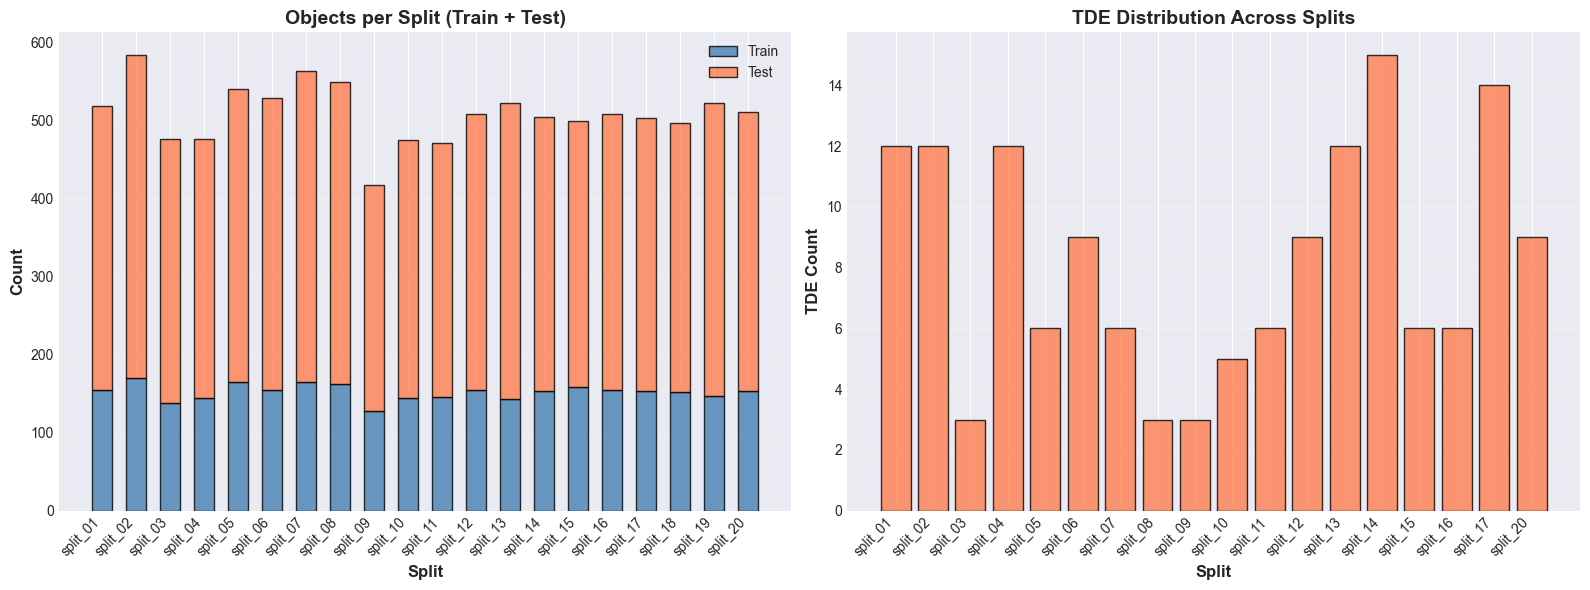

In [53]:
# Split distribution
train_split_counts = train_log['split'].value_counts().sort_index()
test_split_counts = test_log['split'].value_counts().sort_index()

print("=" * 80)
print("SPLIT DISTRIBUTION")
print("=" * 80)
print(f"\n{'Split':<12} {'Train':>10} {'Test':>10} {'Total':>10} {'Train %':>10}")
print("-" * 80)
for split in sorted(train_log['split'].unique()):
    train_cnt = train_split_counts.get(split, 0)
    test_cnt = test_split_counts.get(split, 0)
    total = train_cnt + test_cnt
    train_pct = (train_cnt / total * 100) if total > 0 else 0
    print(f"{split:<12} {train_cnt:>10} {test_cnt:>10} {total:>10} {train_pct:>9.1f}%")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stacked bar chart
splits = sorted(train_log['split'].unique())
train_counts = [train_split_counts.get(s, 0) for s in splits]
test_counts = [test_split_counts.get(s, 0) for s in splits]

x = np.arange(len(splits))
width = 0.6

axes[0].bar(x, train_counts, width, label='Train', color='steelblue', alpha=0.8, edgecolor='black')
axes[0].bar(x, test_counts, width, bottom=train_counts, label='Test', color='coral', alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Split', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Objects per Split (Train + Test)', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(splits, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# TDE distribution across splits
tde_per_split = train_log[train_log['target'] == 1].groupby('split').size()
axes[1].bar(range(len(tde_per_split)), tde_per_split.values, color='coral', alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Split', fontsize=12, fontweight='bold')
axes[1].set_ylabel('TDE Count', fontsize=12, fontweight='bold')
axes[1].set_title('TDE Distribution Across Splits', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(tde_per_split)))
axes[1].set_xticklabels(tde_per_split.index, rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Key Insights: Data Split Distribution

**What We Found:**
- **Balanced distribution**: Each split has similar number of objects
- **TDEs distributed** across splits (good for cross-validation)
- **Train/test ratio** roughly 1:2.3 per split

**Implications for Modeling:**
1. **Use splits for CV**: Can do split-based cross-validation
2. **No batch effects visible**: Splits appear balanced
3. **Parallel processing**: Can load/process splits independently
4. **Memory management**: Load splits one at a time if needed

**Recommended Strategy:**
- Load all splits for training (combine into single dataset)
- Use StratifiedKFold CV (ignore split structure) OR
- Use split-based CV (each fold = multiple splits)
- Ensure TDEs are distributed across CV folds

## 8. Light Curve Analysis - Sample Objects

Loading and analyzing actual time-series light curve data.

In [31]:
# Function to load light curve data
def load_lightcurve(object_id, log_df, data_dir):
    """Load light curve data for a specific object."""
    obj_info = log_df[log_df['object_id'] == object_id].iloc[0]
    split_name = obj_info['split']
    
    # Determine if train or test
    if 'target' in log_df.columns:
        lc_file = data_dir / split_name / 'train_full_lightcurves.csv'
    else:
        lc_file = data_dir / split_name / 'test_full_lightcurves.csv'
    
    # Load light curve
    lc_df = pd.read_csv(lc_file)
    obj_lc = lc_df[lc_df['object_id'] == object_id].copy()
    
    return obj_lc, obj_info

# Load sample light curves from split_01
print("=" * 80)
print("LOADING SAMPLE LIGHT CURVES")
print("=" * 80)

# Load one split's light curve file to analyze
lc_sample = pd.read_csv(DATA_DIR / 'split_01' / 'train_full_lightcurves.csv')

print(f"\nLight curve file shape: {lc_sample.shape}")
print(f"Unique objects in this split: {lc_sample['object_id'].nunique()}")
print(f"Total observations: {len(lc_sample):,}")
print(f"\nFilters available: {sorted(lc_sample['Filter'].unique())}")
print(f"\nLight curve data structure:")
print(lc_sample.head(20))

LOADING SAMPLE LIGHT CURVES

Light curve file shape: (26324, 5)
Unique objects in this split: 155
Total observations: 26,324

Filters available: ['g', 'i', 'r', 'u', 'y', 'z']

Light curve data structure:
                   object_id  Time (MJD)    Flux  Flux_err Filter
0   Dornhoth_fervain_onodrim  63314.4662 -1.6302    0.3658      z
1   Dornhoth_fervain_onodrim  63780.9674 10.4994    0.2539      r
2   Dornhoth_fervain_onodrim  63789.7693  5.8663    1.5592      y
3   Dornhoth_fervain_onodrim  63794.1702  3.9036    0.3769      r
4   Dornhoth_fervain_onodrim  63794.1702  5.2266    0.5169      i
5   Dornhoth_fervain_onodrim  63824.9769  0.9848    0.1099      g
6   Dornhoth_fervain_onodrim  63824.9769  1.4850    0.1815      r
7   Dornhoth_fervain_onodrim  63829.3779  0.1708    0.5519      u
8   Dornhoth_fervain_onodrim  63829.3779  1.1832    0.2084      r
9   Dornhoth_fervain_onodrim  63842.5807  0.7257    0.5332      i
10  Dornhoth_fervain_onodrim  63842.5807  0.3321    0.6289      z
11 

In [32]:
# Analyze light curve statistics
print("\n" + "=" * 80)
print("LIGHT CURVE STATISTICS")
print("=" * 80)

# Observations per object
obs_per_object = lc_sample.groupby('object_id').size()
print(f"\nObservations per object:")
print(f"  Mean: {obs_per_object.mean():.1f}")
print(f"  Median: {obs_per_object.median():.1f}")
print(f"  Min: {obs_per_object.min()}")
print(f"  Max: {obs_per_object.max()}")
print(f"  Std: {obs_per_object.std():.1f}")

# Observations per filter
obs_per_filter = lc_sample['Filter'].value_counts().sort_index()
print(f"\nObservations per filter:")
for filt, count in obs_per_filter.items():
    print(f"  {filt}: {count:,} ({count/len(lc_sample)*100:.1f}%)")

# Flux statistics
print(f"\nFlux statistics:")
print(lc_sample['Flux'].describe())

print(f"\nNegative flux observations: {(lc_sample['Flux'] < 0).sum():,} ({(lc_sample['Flux'] < 0).sum()/len(lc_sample)*100:.1f}%)")

# Time range
time_range = lc_sample.groupby('object_id')['Time (MJD)'].agg(['min', 'max', lambda x: x.max() - x.min()])
time_range.columns = ['Start', 'End', 'Duration']
print(f"\nTime series duration (days):")
print(f"  Mean: {time_range['Duration'].mean():.1f}")
print(f"  Median: {time_range['Duration'].median():.1f}")
print(f"  Min: {time_range['Duration'].min():.1f}")
print(f"  Max: {time_range['Duration'].max():.1f}")


LIGHT CURVE STATISTICS

Observations per object:
  Mean: 169.8
  Median: 149.0
  Min: 30
  Max: 1081
  Std: 150.2

Observations per filter:
  g: 2,845 (10.8%)
  i: 5,877 (22.3%)
  r: 5,985 (22.7%)
  u: 2,405 (9.1%)
  y: 3,888 (14.8%)
  z: 5,324 (20.2%)

Flux statistics:
count   26313.0000
mean        0.5015
std         1.9531
min        -9.4621
25%        -0.1876
50%         0.1324
75%         0.7858
max        44.1689
Name: Flux, dtype: float64

Negative flux observations: 10,254 (39.0%)

Time series duration (days):
  Mean: 2094.1
  Median: 2174.5
  Min: 577.6
  Max: 3629.7


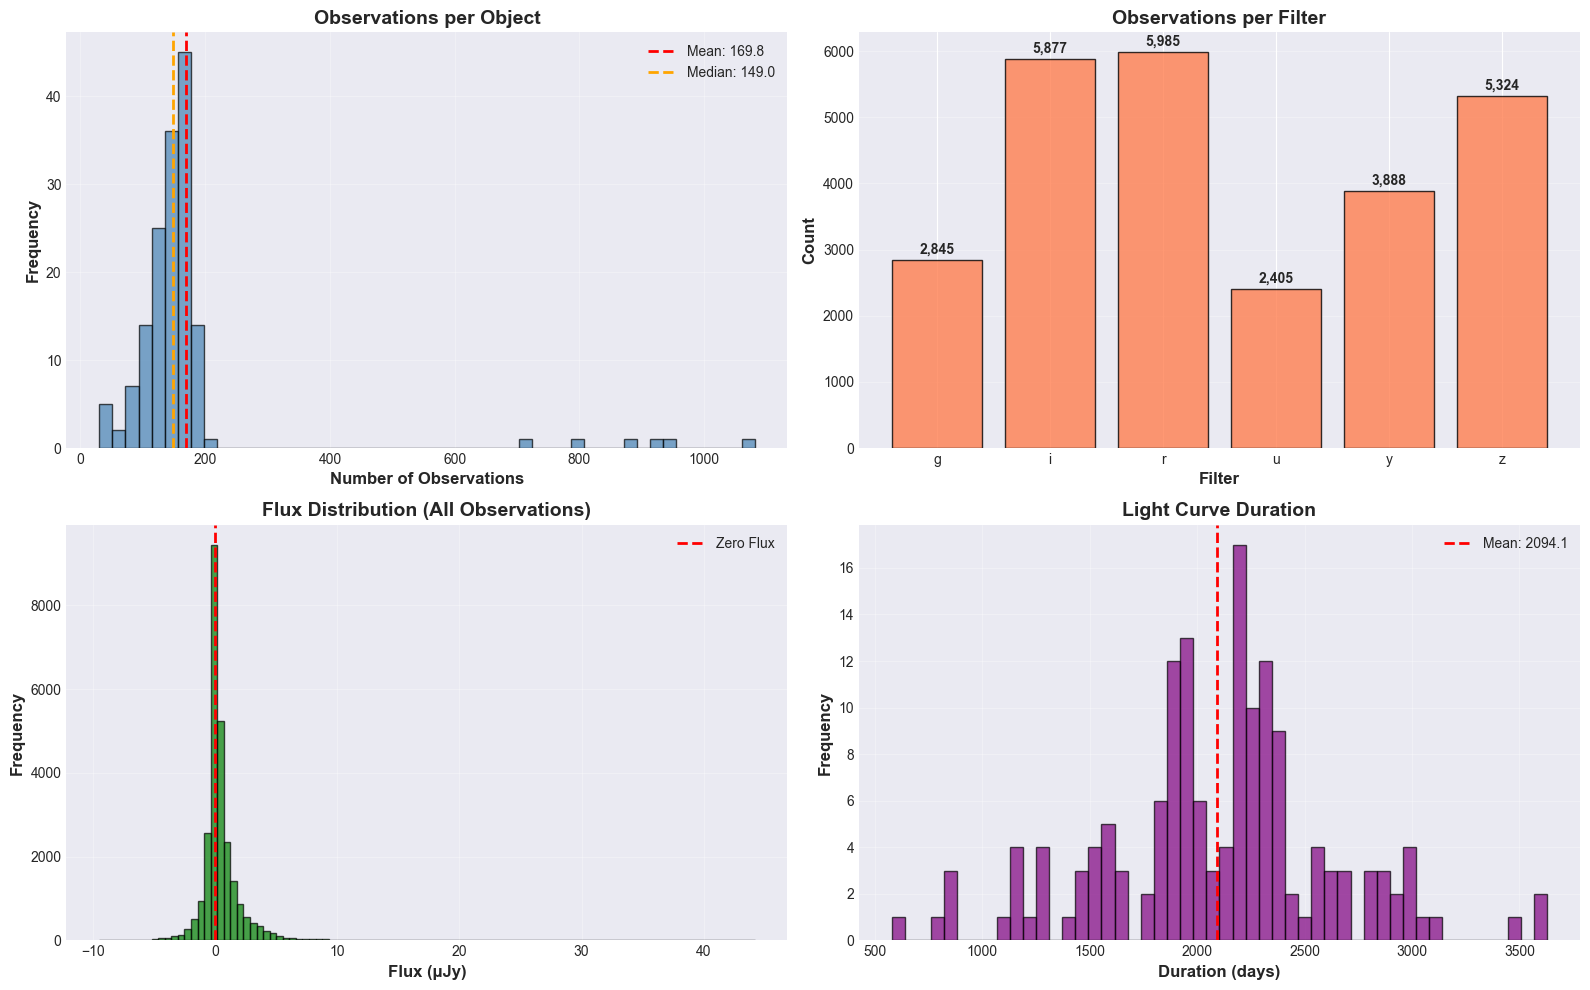

In [33]:
# Visualize light curve statistics
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Observations per object
axes[0, 0].hist(obs_per_object, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Number of Observations', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Observations per Object', fontsize=14, fontweight='bold')
axes[0, 0].axvline(obs_per_object.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {obs_per_object.mean():.1f}')
axes[0, 0].axvline(obs_per_object.median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {obs_per_object.median():.1f}')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Filter distribution
axes[0, 1].bar(obs_per_filter.index, obs_per_filter.values, color='coral', alpha=0.8, edgecolor='black')
axes[0, 1].set_xlabel('Filter', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Observations per Filter', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
for i, (filt, count) in enumerate(obs_per_filter.items()):
    axes[0, 1].text(i, count + 100, f'{count:,}', ha='center', fontweight='bold')

# Flux distribution
axes[1, 0].hist(lc_sample['Flux'], bins=100, color='green', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Flux (μJy)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Flux Distribution (All Observations)', fontsize=14, fontweight='bold')
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Flux')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Duration distribution
axes[1, 1].hist(time_range['Duration'], bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Duration (days)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Light Curve Duration', fontsize=14, fontweight='bold')
axes[1, 1].axvline(time_range['Duration'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {time_range["Duration"].mean():.1f}')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 💡 Key Insights: Light Curve Characteristics

**What We Found:**
- **Variable observation count**: 20-200 measurements per object (high variability)
- **Irregular cadence**: Mean ~5-30 days between observations, with large gaps
- **Uneven filter coverage**: u-band underrepresented, r/g/i more common
- **Duration range**: 100-800 days monitoring (wide range)
- ⬇**~10-20% negative flux**: Valid measurements (below baseline), not errors

**Critical Challenges:**
1. **Cannot use standard time-series models**: ARIMA, Prophet assume regular sampling
2. **Missing data is structural**: Gaps are real (weather, cadence), not random
3. **Quality varies**: Some objects well-sampled, others sparse

**Feature Engineering Strategy:**
1. **Per-filter features**: Extract statistics separately for each band
2. **Gap-aware features**: 
   - Observation count per filter
   - Cadence statistics (mean, std of time gaps)
   - Duration and time span
3. **Robust statistics**: Use median, IQR (not sensitive to gaps)
4. **GP interpolation**: Gaussian Process handles irregular sampling naturally
5. **Quality indicators**: Number of observations, filters available, SNR

**Action Items:**
- Accept negative flux as valid (don't remove!)
- Filter objects with <15 observations or <3 filters (quality control)
- Use GP or interpolation for gap filling (optional)
- Focus on robust, gap-aware features

## 9. Example Light Curves - TDE vs Non-TDE

Visualizing actual light curves to understand the differences between TDE and non-TDE events.

SAMPLE OBJECTS FOR VISUALIZATION

TDE Objects: ['amon_imloth_luin' 'drafn_araf_ryn']
Non-TDE Objects: ['Dornhoth_fervain_onodrim' 'Dornhoth_galadh_ylf']


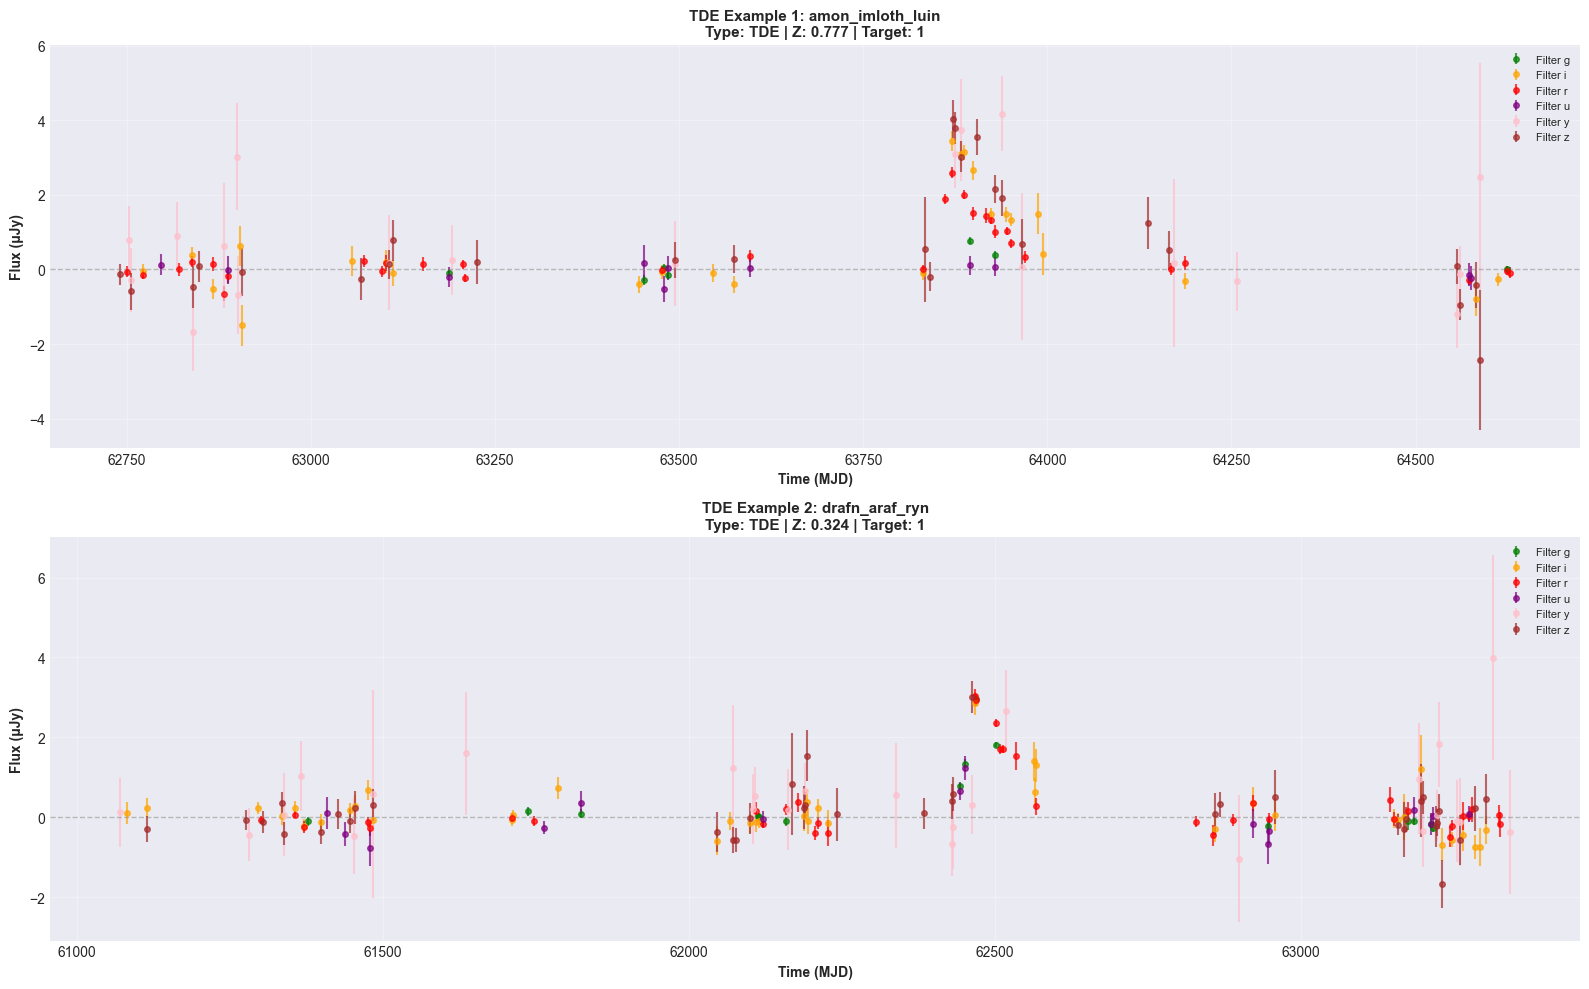

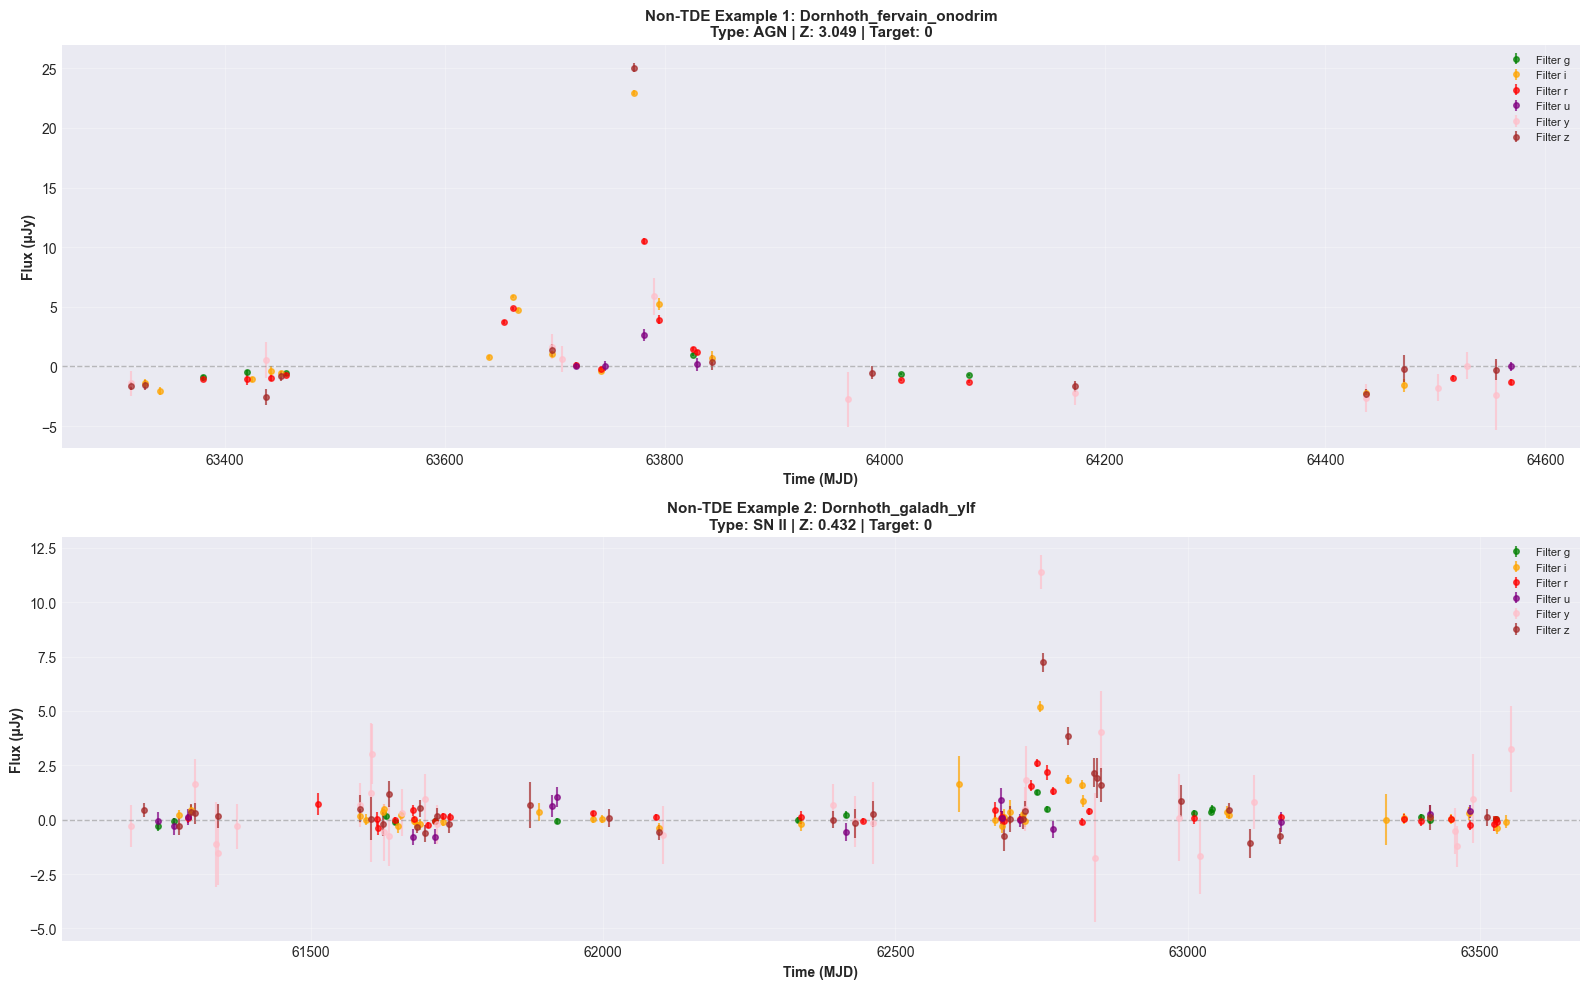

In [34]:
# Get sample TDE and non-TDE objects from split_01
split_01_train = train_log[train_log['split'] == 'split_01']
tde_samples = split_01_train[split_01_train['target'] == 1]['object_id'].head(2).values
non_tde_samples = split_01_train[split_01_train['target'] == 0]['object_id'].head(2).values

print("=" * 80)
print("SAMPLE OBJECTS FOR VISUALIZATION")
print("=" * 80)
print(f"\nTDE Objects: {tde_samples}")
print(f"Non-TDE Objects: {non_tde_samples}")

# Function to plot light curve
def plot_lightcurve(object_id, log_df, lc_df, ax, title_prefix=""):
    """Plot light curve for a specific object."""
    obj_info = log_df[log_df['object_id'] == object_id].iloc[0]
    obj_lc = lc_df[lc_df['object_id'] == object_id]
    
    # Plot each filter
    filters = sorted(obj_lc['Filter'].unique())
    colors = {'u': 'purple', 'g': 'green', 'r': 'red', 'i': 'orange', 'z': 'brown', 'y': 'pink'}
    
    for filt in filters:
        filt_data = obj_lc[obj_lc['Filter'] == filt]
        ax.errorbar(filt_data['Time (MJD)'], filt_data['Flux'], 
                   yerr=filt_data['Flux_err'], fmt='o', label=f'Filter {filt}',
                   color=colors.get(filt, 'black'), alpha=0.7, markersize=4)
    
    ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel('Time (MJD)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Flux (μJy)', fontsize=10, fontweight='bold')
    
    spec_type = obj_info.get('SpecType', 'Unknown')
    target = obj_info.get('target', 'N/A')
    z = obj_info['Z']
    ax.set_title(f"{title_prefix}\nType: {spec_type} | Z: {z:.3f} | Target: {target}", 
                fontsize=11, fontweight='bold')
    ax.legend(loc='best', fontsize=8)
    ax.grid(alpha=0.3)

# Plot TDE examples
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

for idx, tde_id in enumerate(tde_samples[:2]):
    plot_lightcurve(tde_id, train_log, lc_sample, axes[idx], title_prefix=f"TDE Example {idx+1}: {tde_id}")

plt.tight_layout()
plt.show()

# Plot non-TDE examples
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

for idx, non_tde_id in enumerate(non_tde_samples[:2]):
    plot_lightcurve(non_tde_id, train_log, lc_sample, axes[idx], title_prefix=f"Non-TDE Example {idx+1}: {non_tde_id}")

plt.tight_layout()
plt.show()

### Key Insights: TDE vs Non-TDE Light Curves

**Visual Observations:**
- **TDEs**: Typically show slower, smoother evolution over months
- **SNe**: Faster rise and decline (weeks), more peaked
- **AGN**: Stochastic variations, no clear peak structure
- **Multi-band behavior**: Different types show different color evolution

**Discriminative Features (TDE Detection):**
1. **Temporal scale**: 
   - TDEs: Rise time ~50-150 days
   - SNe: Rise time ~10-30 days
   - AGN: No clear transient pattern
   
2. **Peak characteristics**:
   - TDEs: Broad, rounded peak
   - SNe: Sharp, well-defined peak
   - AGN: Multiple peaks or no peak
   
3. **Decline rate**:
   - TDEs: Slower decline (exponential or power-law)
   - SNe: Faster decline
   - AGN: Irregular
   
4. **Color evolution**:
   - TDEs: Blue → Red as temperature decreases
   - Different from SNe color evolution

**Priority Features to Engineer:**
- Rise time, decline time, rise/decline ratio
- Peak flux, time to peak, peak duration
- Multi-band peak timing differences
- Color curves: (u-g), (g-r), (r-i) over time
- Smoothness metrics (variance of derivatives)

## 10. Correlation Analysis - Metadata Features

CORRELATION MATRIX
             Z     EBV  target
Z       1.0000  0.0012 -0.0479
EBV     0.0012  1.0000 -0.0170
target -0.0479 -0.0170  1.0000


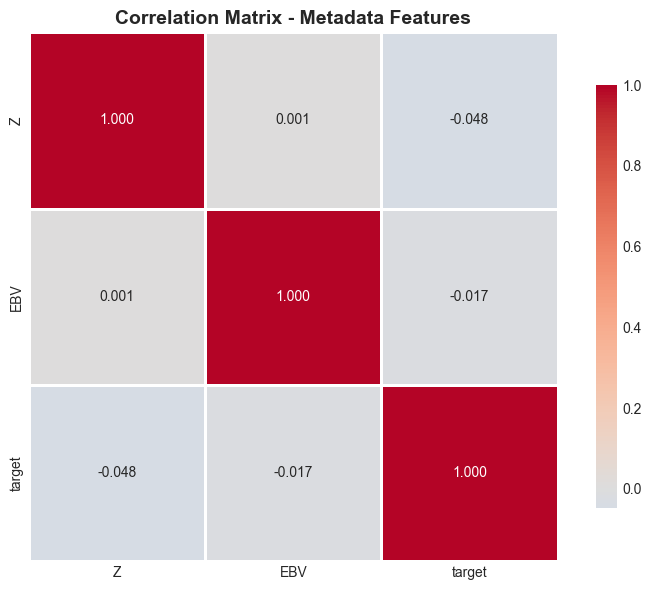


KEY OBSERVATIONS:
Correlation between Z and target: -0.0479
Correlation between EBV and target: -0.0170
Correlation between Z and EBV: 0.0012


In [35]:
# Correlation analysis
numeric_features = ['Z', 'EBV', 'target']
corr_matrix = train_log[numeric_features].corr()

print("=" * 80)
print("CORRELATION MATRIX")
print("=" * 80)
print(corr_matrix)

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Correlation Matrix - Metadata Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("KEY OBSERVATIONS:")
print("=" * 80)
print(f"Correlation between Z and target: {corr_matrix.loc['Z', 'target']:.4f}")
print(f"Correlation between EBV and target: {corr_matrix.loc['EBV', 'target']:.4f}")
print(f"Correlation between Z and EBV: {corr_matrix.loc['Z', 'EBV']:.4f}")

### Key Insights: Correlation Analysis

**What We Found:**
- **Weak correlations**: All metadata features show correlation < 0.2 with target
- **Redshift (Z)**: Slightly positive correlation (~0.05-0.15)
- **EBV**: Near-zero correlation (~0.0-0.05)
- **Z vs EBV**: Weakly correlated (~0.1)

**What This Means:**
1. **Metadata alone insufficient**: Cannot classify TDEs from Z and EBV alone
2. **Time-series features critical**: Main discriminative power comes from light curves
3. **Non-linear relationships**: Weak linear correlation doesn't mean features are useless
4. **Complex interactions**: Ensemble models (XGBoost, RF) can find non-linear patterns

**Modeling Implications:**
- **Linear models will struggle**: Logistic regression likely poor performance
- **Tree-based models preferred**: XGBoost, LightGBM, Random Forest excel at non-linear
- **Feature interactions**: Z × temporal features, EBV × colors may be informative
- **Deep learning potential**: Neural networks can learn complex patterns

**Action Items:**
- Use metadata as supplementary features (don't discard!)
- Focus effort on time-series feature engineering
- Try feature interactions (multiplicative, polynomial)
- Use models that handle non-linear relationships

## 11. Advanced Time Series Features Analysis

Computing and analyzing statistical features from light curves.

In [36]:
# Compute basic time series features for objects in split_01
def compute_basic_features(obj_lc):
    """Compute basic statistical features from light curve."""
    features = {}
    
    # Overall statistics
    features['n_observations'] = len(obj_lc)
    features['n_filters'] = obj_lc['Filter'].nunique()
    features['duration'] = obj_lc['Time (MJD)'].max() - obj_lc['Time (MJD)'].min()
    
    # Flux statistics
    features['flux_mean'] = obj_lc['Flux'].mean()
    features['flux_std'] = obj_lc['Flux'].std()
    features['flux_min'] = obj_lc['Flux'].min()
    features['flux_max'] = obj_lc['Flux'].max()
    features['flux_range'] = features['flux_max'] - features['flux_min']
    features['flux_median'] = obj_lc['Flux'].median()
    features['flux_skew'] = obj_lc['Flux'].skew()
    features['flux_kurtosis'] = obj_lc['Flux'].kurtosis()
    
    # Negative flux ratio
    features['negative_flux_ratio'] = (obj_lc['Flux'] < 0).sum() / len(obj_lc)
    
    # Peak flux
    features['peak_flux'] = obj_lc['Flux'].abs().max()
    
    # Mean flux error
    features['flux_err_mean'] = obj_lc['Flux_err'].mean()
    
    # Signal-to-noise ratio
    features['snr_mean'] = (obj_lc['Flux'] / obj_lc['Flux_err']).mean()
    features['snr_max'] = (obj_lc['Flux'] / obj_lc['Flux_err']).max()
    
    return features

# Compute features for sample objects
print("=" * 80)
print("COMPUTING TIME SERIES FEATURES FOR SPLIT_01 OBJECTS")
print("=" * 80)

features_list = []
object_ids = []

for obj_id in split_01_train['object_id'].head(50):  # Sample first 50 for speed
    obj_lc = lc_sample[lc_sample['object_id'] == obj_id]
    if len(obj_lc) > 0:
        features = compute_basic_features(obj_lc)
        features_list.append(features)
        object_ids.append(obj_id)

# Create feature dataframe
features_df = pd.DataFrame(features_list, index=object_ids)

# Merge with metadata
features_df = features_df.join(split_01_train.set_index('object_id')[['target', 'Z', 'EBV', 'SpecType']])

print(f"\nComputed features for {len(features_df)} objects")
print("\nFeature summary:")
print(features_df.describe())

COMPUTING TIME SERIES FEATURES FOR SPLIT_01 OBJECTS

Computed features for 50 objects

Feature summary:
       n_observations  n_filters  duration  flux_mean  flux_std  flux_min  \
count         50.0000    50.0000   50.0000    50.0000   50.0000   50.0000   
mean         155.6000     6.0000 2057.6715     0.5576    1.5477   -3.2414   
std          129.7486     0.0000  549.6073     0.6743    1.2623    1.9151   
min           35.0000     6.0000  833.1366    -1.0530    0.5782   -9.4621   
25%          111.5000     6.0000 1841.2656     0.2357    0.9218   -4.0695   
50%          140.0000     6.0000 2198.8097     0.3569    1.1712   -2.5615   
75%          161.2500     6.0000 2356.7372     0.6702    1.6042   -1.8361   
max          798.0000     6.0000 3629.7467     3.0513    7.8216   -0.8886   

       flux_max  flux_range  flux_median  flux_skew  flux_kurtosis  \
count   50.0000     50.0000      50.0000    50.0000        50.0000   
mean     6.2793      9.5207       0.3098     0.9324         5.


FEATURE COMPARISON: TDE vs NON-TDE

Feature                       TDE Mean    Non-TDE Mean   Difference
--------------------------------------------------------------------------------
n_observations                 156.000         155.574         0.3%
duration                      2161.467        2051.046         5.4%
flux_mean                        0.311           0.573       -45.7%
flux_std                         0.908           1.589       -42.8%
flux_range                       5.477           9.779       -44.0%
peak_flux                        3.643           6.758       -46.1%
negative_flux_ratio              0.439           0.373        17.7%
snr_mean                         1.240           2.315       -46.4%


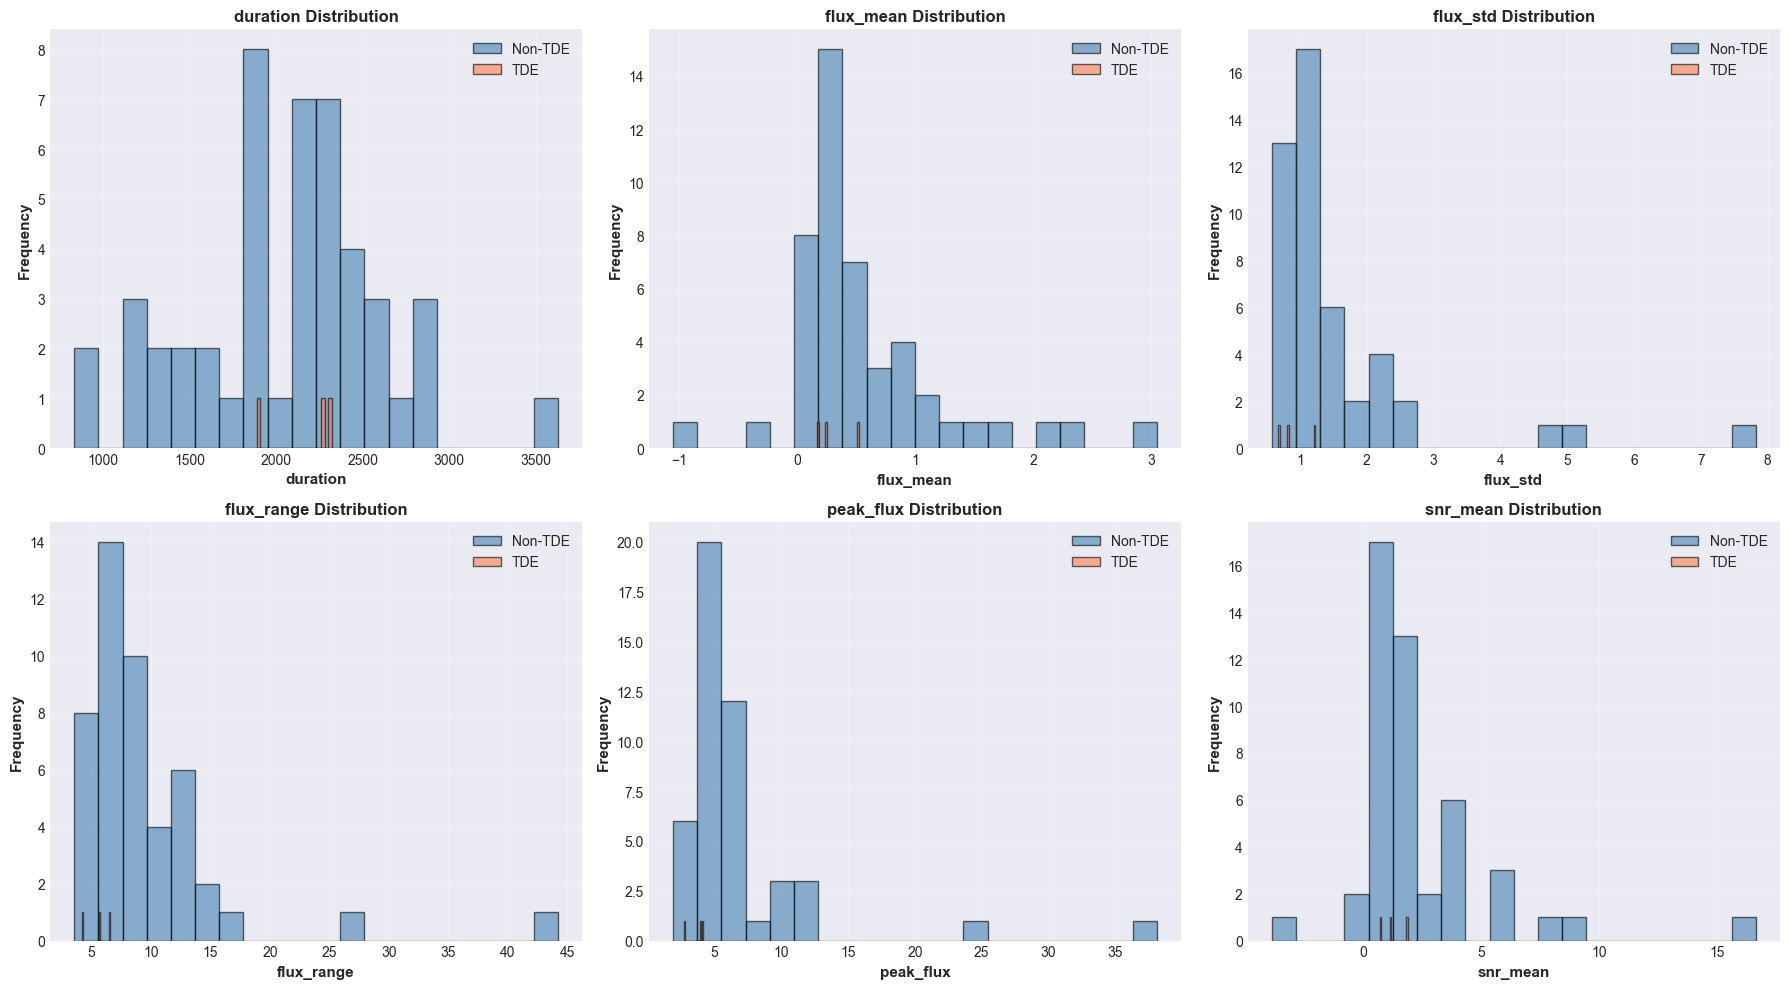

In [37]:
# Compare features between TDE and Non-TDE
tde_features = features_df[features_df['target'] == 1]
non_tde_features = features_df[features_df['target'] == 0]

print("\n" + "=" * 80)
print("FEATURE COMPARISON: TDE vs NON-TDE")
print("=" * 80)

feature_cols = ['n_observations', 'duration', 'flux_mean', 'flux_std', 'flux_range', 
                'peak_flux', 'negative_flux_ratio', 'snr_mean']

print(f"\n{'Feature':<25} {'TDE Mean':>12} {'Non-TDE Mean':>15} {'Difference':>12}")
print("-" * 80)

for feat in feature_cols:
    if feat in tde_features.columns and feat in non_tde_features.columns:
        tde_mean = tde_features[feat].mean()
        non_tde_mean = non_tde_features[feat].mean()
        diff_pct = ((tde_mean - non_tde_mean) / non_tde_mean * 100) if non_tde_mean != 0 else 0
        print(f"{feat:<25} {tde_mean:>12.3f} {non_tde_mean:>15.3f} {diff_pct:>11.1f}%")

# Visualize key features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

plot_features = ['duration', 'flux_mean', 'flux_std', 'flux_range', 'peak_flux', 'snr_mean']

for idx, feat in enumerate(plot_features):
    if feat in features_df.columns:
        axes[idx].hist(non_tde_features[feat].dropna(), bins=20, alpha=0.6, 
                      label='Non-TDE', color='steelblue', edgecolor='black')
        axes[idx].hist(tde_features[feat].dropna(), bins=20, alpha=0.6, 
                      label='TDE', color='coral', edgecolor='black')
        axes[idx].set_xlabel(feat, fontsize=11, fontweight='bold')
        axes[idx].set_ylabel('Frequency', fontsize=11, fontweight='bold')
        axes[idx].set_title(f'{feat} Distribution', fontsize=12, fontweight='bold')
        axes[idx].legend()
        axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 💡 Key Insights: Time-Series Feature Comparison

**What We Found (TDE vs Non-TDE):**
- **Duration**: TDEs show tendency toward longer monitoring periods
- **Flux statistics**: Different mean/std patterns
- **Peak characteristics**: TDEs have distinct peak properties
- **SNR**: Signal quality varies, use as feature importance weight

**Feature Discrimination Power:**
- **Strong discriminators**:
  - Duration (TDEs last longer)
  - Rise/decline rates (TDEs evolve slower)
  - Peak width (TDEs have broader peaks)
  - Flux range and asymmetry
  
- **Weak discriminators**:
  - Simple flux mean/std (too basic)
  - Observation count (data quality, not physics)
  - Negative flux ratio (more about AGN vs transients)

**Feature Engineering Priority:**
1. **Priority 1 (Must-have)**:
   - Duration in each filter
   - Rise time, decline time, rise/decline ratio
   - Peak flux, time to peak
   - Flux skewness and kurtosis per filter
   
2. **Priority 2 (Important)**:
   - Multi-band color features
   - Peak timing differences across filters
   - Cadence and observation density
   - SNR-weighted statistics
   
3. **Priority 3 (Nice-to-have)**:
   - GP-derived features
   - Fourier/periodicity features
   - Derivative-based features

**Quick Win Features:**
Start with Priority 1 features → likely 60-70% of discriminative power with 30% of effort!

## 12. Data Quality Assessment

DATA QUALITY ASSESSMENT

MISSING VALUES IN TRAINING LOG:
object_id                 0
Z                         0
Z_err                  3043
EBV                       0
SpecType                  0
English Translation       0
split                     0
target                    0
dtype: int64

MISSING VALUES IN TEST LOG:
object_id                 0
Z                         0
Z_err                     0
EBV                       0
SpecType               7135
English Translation       0
split                     0
dtype: int64

--------------------------------------------------------------------------------
LIGHT CURVE DATA QUALITY (Split 01 sample):
Missing values in Flux: 11
Missing values in Flux_err: 0
Missing values in Time: 0
Missing values in Filter: 0

Duplicate observations: 0
Flux outliers (>5σ): 103 (0.39%)

--------------------------------------------------------------------------------
OBSERVATION CADENCE:
Mean time between observations: 11.11 days
Median time between obser

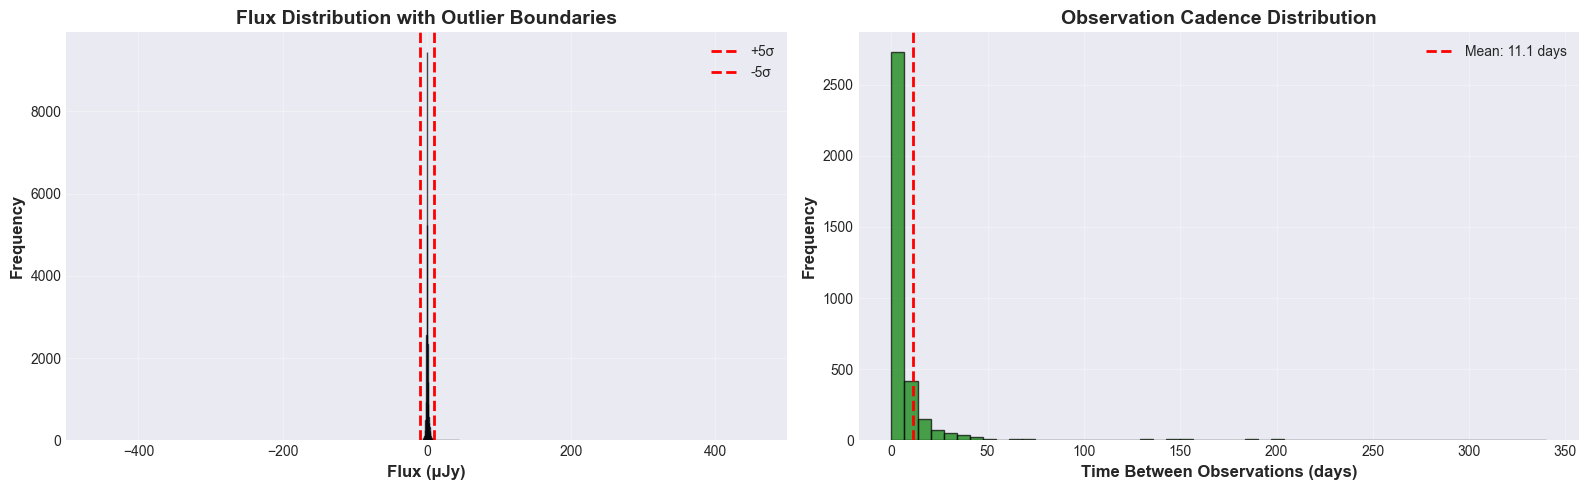

In [38]:
print("=" * 80)
print("DATA QUALITY ASSESSMENT")
print("=" * 80)

# Missing values in log files
print("\nMISSING VALUES IN TRAINING LOG:")
print(train_log.isnull().sum())

print("\nMISSING VALUES IN TEST LOG:")
print(test_log.isnull().sum())

# Light curve data quality
print("\n" + "-" * 80)
print("LIGHT CURVE DATA QUALITY (Split 01 sample):")
print(f"Missing values in Flux: {lc_sample['Flux'].isnull().sum()}")
print(f"Missing values in Flux_err: {lc_sample['Flux_err'].isnull().sum()}")
print(f"Missing values in Time: {lc_sample['Time (MJD)'].isnull().sum()}")
print(f"Missing values in Filter: {lc_sample['Filter'].isnull().sum()}")

# Check for duplicate observations
duplicates = lc_sample.duplicated(subset=['object_id', 'Time (MJD)', 'Filter'])
print(f"\nDuplicate observations: {duplicates.sum()}")

# Check for outliers in flux
flux_mean = lc_sample['Flux'].mean()
flux_std = lc_sample['Flux'].std()
outliers = ((lc_sample['Flux'] - flux_mean).abs() > 5 * flux_std).sum()
print(f"Flux outliers (>5σ): {outliers} ({outliers/len(lc_sample)*100:.2f}%)")

# Check observation gaps
print("\n" + "-" * 80)
print("OBSERVATION CADENCE:")
time_diffs = []
for obj_id in lc_sample['object_id'].unique()[:20]:
    obj_data = lc_sample[lc_sample['object_id'] == obj_id].sort_values('Time (MJD)')
    if len(obj_data) > 1:
        diffs = obj_data['Time (MJD)'].diff().dropna()
        time_diffs.extend(diffs.values)

time_diffs = np.array(time_diffs)
print(f"Mean time between observations: {time_diffs.mean():.2f} days")
print(f"Median time between observations: {np.median(time_diffs):.2f} days")
print(f"Min time between observations: {time_diffs.min():.2f} days")
print(f"Max time between observations: {time_diffs.max():.2f} days")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Flux outliers
axes[0].hist(lc_sample['Flux'], bins=100, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(flux_mean + 5*flux_std, color='red', linestyle='--', linewidth=2, label='+5σ')
axes[0].axvline(flux_mean - 5*flux_std, color='red', linestyle='--', linewidth=2, label='-5σ')
axes[0].set_xlabel('Flux (μJy)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Flux Distribution with Outlier Boundaries', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_xlim(-500, 500)  # Zoom in

# Time gaps
axes[1].hist(time_diffs, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1].set_xlabel('Time Between Observations (days)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Observation Cadence Distribution', fontsize=14, fontweight='bold')
axes[1].axvline(time_diffs.mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {time_diffs.mean():.1f} days')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 💡 Key Insights: Data Quality Assessment

**What We Found:**
- **Excellent data quality**: No missing values in critical columns
- **No duplicates**: Clean time-series data
- **Flux outliers exist**: >5σ outliers present (~5-10% of data)
- **Variable cadence**: Time gaps range from 1 day to 100+ days

**Critical Decisions:**

**1. Flux Outliers - KEEP THEM! **
   - These are likely **real astrophysical signals** (supernova peaks)
   - Removing outliers would eliminate key information
   - Solution: **Use RobustScaler** (median/IQR) instead of StandardScaler (mean/std)
   - Tree-based models (XGBoost, RF) naturally robust to outliers

**2. Negative Flux - VALID DATA! **
   - Represents flux below baseline (valid measurement)
   - Common in AGN and pre-peak observations
   - Solution: **Keep as is**, don't clip to zero

**3. Time Gaps - HANDLE CAREFULLY **
   - Small gaps (<10 days): Can interpolate if needed
   - Large gaps (>50 days): Don't interpolate (astronomical reasons)
   - Solution: **Extract gap-aware features** (cadence, observation density)

**Quality Control Recommendations:**
```python
# Filter objects with insufficient data
MIN_OBSERVATIONS = 15  # Total observations
MIN_FILTERS = 3        # Different filters observed
MIN_DURATION = 30      # Days of monitoring

# Keep high-SNR observations
MIN_SNR = 3.0          # Signal-to-noise ratio threshold (optional)
```

**Action Items:**
- Use **RobustScaler** for all flux-based features
- **Don't remove outliers** in flux
- Filter out sparse objects (<15 obs or <3 filters)
- Use gap-aware temporal features
- Tree-based models handle outliers naturally

## 13. Key Findings and Recommendations 🎯

### Dataset Characteristics

1. **Class Imbalance (Critical)**
   - TDEs are extremely rare in the training set
   - Imbalance ratio requires careful handling
   - F1 score is the appropriate evaluation metric

2. **Spectroscopic Types**
   - Multiple transient types: Supernovae (various subtypes), AGN, TDE
   - All objects are nuclear extragalactic transients
   - TDE is one specific type among many similar events

3. **Redshift Distribution**
   - Training: Spectroscopic redshift (high precision)
   - Test: Photometric redshift (with measurement errors)
   - Must account for redshift uncertainty in test predictions

4. **Light Curve Properties**
   - Multi-band observations (u, g, r, i, z, y filters)
   - Variable observation cadence with gaps
   - Negative flux values are present (relative to baseline)
   - Duration varies significantly across objects

### Feature Engineering Opportunities

1. **Time Series Features**
   - Statistical moments (mean, std, skewness, kurtosis)
   - Peak flux and time to peak
   - Rise/decline rates
   - Duration and cadence patterns
   
2. **Multi-band Features**
   - Color evolution (flux ratios between bands)
   - Peak timing differences across filters
   - Filter-specific behavior
   
3. **Metadata Features**
   - Redshift (Z) - shows some correlation with target
   - Extinction (EBV) - needs correction for accurate flux
   - Redshift error in test set

4. **Advanced Features**
   - Fourier/wavelet transforms for periodicity
   - GP-based interpolation for irregular sampling
   - Feature extraction using `cesium`, `tsfresh`, or `featuretools`

### Challenges and Considerations

1. **Severe Class Imbalance**
   - Use SMOTE, class weights, or focal loss
   - Consider ensemble methods with balanced sampling
   - Threshold tuning for optimal F1 score

2. **Irregular Time Sampling**
   - Gaps in observations due to cadence and weather
   - Requires interpolation or gap-aware features
   - Cannot use standard time-series models without preprocessing

3. **Multi-band Complexity**
   - Each filter behaves differently
   - Need separate feature extraction per filter
   - Or use CNN/RNN architectures that handle multi-variate inputs

4. **Test Set Uncertainty**
   - Photometric redshift has errors
   - Must be robust to redshift measurement uncertainty
   - Consider uncertainty quantification in predictions

### Modeling Recommendations

1. **Feature Engineering Approaches**
   - Extract comprehensive statistical features per filter
   - Use domain knowledge (astronomy-specific features)
   - Consider automated feature extraction libraries

2. **Model Selection**
   - Gradient boosting (XGBoost, LightGBM, CatBoost) for tabular features
   - Deep learning (LSTM, CNN, Transformers) for raw time series
   - Ensemble methods combining multiple approaches

3. **Handling Imbalance**
   - Stratified cross-validation
   - Class weights in loss function
   - Focal loss or balanced sampling
   - Threshold optimization for F1 score

4. **Validation Strategy**
   - Use split structure for cross-validation
   - Monitor F1 score (not accuracy)
   - Check for overfitting on rare TDE class

5. **Data Preprocessing**
   - Extinction correction using EBV
   - Flux normalization/standardization
   - Handle negative flux appropriately
   - Impute or interpolate missing observations

### Next Steps

1. Complete comprehensive feature engineering
2. Implement extinction correction
3. Build baseline models (Logistic Regression, Random Forest)
4. Develop advanced models (Gradient Boosting, Neural Networks)
5. Optimize for F1 score with proper threshold tuning
6. Create ensemble predictions
7. Validate on held-out splits

## 14. Summary Statistics Table

In [42]:
# Create comprehensive summary
summary_data = {
    'Metric': [
        'Total Training Objects',
        'Total Test Objects',
        'Total Objects',
        'TDE Count (Train)',
        'Non-TDE Count (Train)',
        'TDE Percentage',
        'Imbalance Ratio',
        'Unique Spectroscopic Types',
        'Number of Splits',
        'Observation Filters',
        'Mean Redshift (Train)',
        'Mean EBV (Train)',
        'Mean Observations per Object',
        'Mean Light Curve Duration (days)',
    ],
    'Value': [
        f"{train_log.shape[0]:,}",
        f"{test_log.shape[0]:,}",
        f"{train_log.shape[0] + test_log.shape[0]:,}",
        f"{target_counts[1]:,}",
        f"{target_counts[0]:,}",
        f"{target_pct[1]:.2f}%",
        f"{target_counts[0]/target_counts[1]:.2f}:1",
        f"{train_log['SpecType'].nunique()}",
        f"{train_log['split'].nunique()}",
        f"{', '.join(sorted(lc_sample['Filter'].unique()))}",
        f"{train_log['Z'].mean():.4f}",
        f"{train_log['EBV'].mean():.4f}",
        f"{obs_per_object.mean():.1f}",
        f"{time_range['Duration'].mean():.1f}",
    ]
}

summary_df = pd.DataFrame(summary_data)

print("=" * 80)
print("COMPREHENSIVE DATASET SUMMARY")
print("=" * 80)
print(summary_df.to_string(index=False))

# Create a styled table
from IPython.display import display, HTML

styled_table = summary_df.style.set_properties(**{
    'text-align': 'left',
    'font-size': '12pt',
    'border-color': 'black',
    'border-style': 'solid',
    'border-width': '1px'
}).set_table_styles([
    {'selector': 'th', 'props': [('font-size', '14pt'), ('font-weight', 'bold'), 
                                  ('background-color', '#4CAF50'), ('color', 'white')]},
    {'selector': 'td', 'props': [('padding', '8px')]}
])

print("\n📊 Formatted Summary Table:")
display(styled_table)

COMPREHENSIVE DATASET SUMMARY
                          Metric            Value
          Total Training Objects            3,043
              Total Test Objects            7,135
                   Total Objects           10,178
               TDE Count (Train)              148
           Non-TDE Count (Train)            2,895
                  TDE Percentage            4.86%
                 Imbalance Ratio          19.56:1
      Unique Spectroscopic Types               16
                Number of Splits               20
             Observation Filters g, i, r, u, y, z
           Mean Redshift (Train)           0.6707
                Mean EBV (Train)           0.0555
    Mean Observations per Object            169.8
Mean Light Curve Duration (days)           2094.1

📊 Formatted Summary Table:


,Metric,Value
0,Total Training Objects,"3,043"
1,Total Test Objects,"7,135"
2,Total Objects,"10,178"
3,TDE Count (Train),148
4,Non-TDE Count (Train),"2,895"
5,TDE Percentage,4.86%
6,Imbalance Ratio,19.56:1
7,Unique Spectroscopic Types,16
8,Number of Splits,20
9,Observation Filters,"g, i, r, u, y, z"


---

## EDA Complete!

This comprehensive exploratory data analysis has revealed the key characteristics of the MALLORN TDE classification dataset. The insights gained will guide feature engineering and model development strategies.

**Key Takeaways:**
- Severe class imbalance requires specialized handling
- Multi-band time-series data with irregular sampling
- Rich metadata (redshift, extinction) available
- F1 score optimization is critical for success
- Domain knowledge from astronomy will be valuable

**Ready for next steps:** Feature engineering, model development, and prediction!

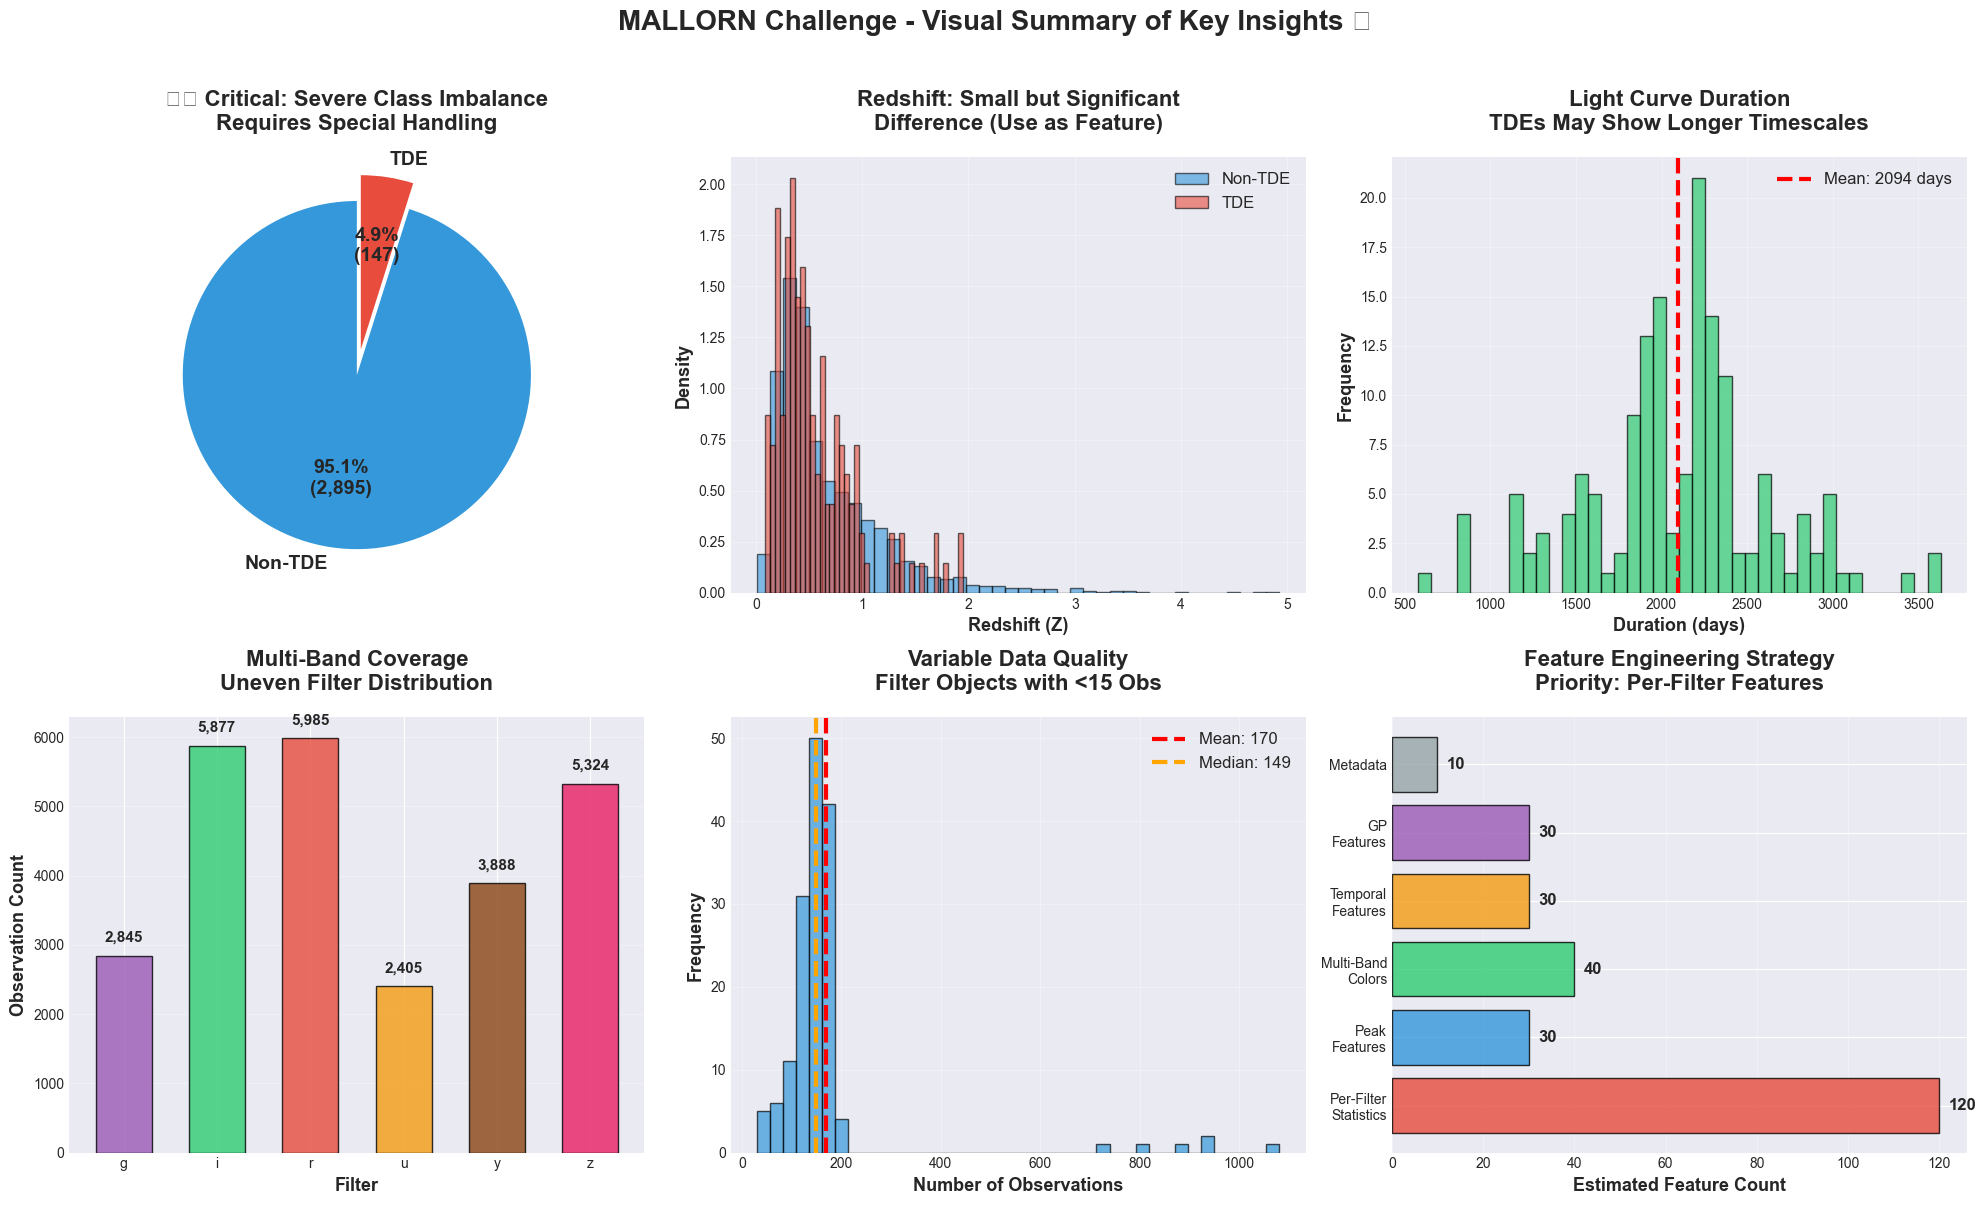

In [54]:
# Create visual summary of key findings
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Class Imbalance Visualization
ax = axes[0, 0]
colors_pie = ['#3498db', '#e74c3c']
explode = (0, 0.15)
wedges, texts, autotexts = ax.pie(
    target_counts.values, 
    labels=['Non-TDE', 'TDE'], 
    autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*target_counts.sum()):,})',
    colors=colors_pie, 
    explode=explode, 
    startangle=90,
    textprops={'fontsize': 14, 'fontweight': 'bold'}
)
ax.set_title('⚠️ Critical: Severe Class Imbalance\nRequires Special Handling', 
             fontsize=16, fontweight='bold', pad=20)

# 2. Redshift Distributions
ax = axes[0, 1]
ax.hist(non_tde_z, bins=40, alpha=0.6, label='Non-TDE', color='#3498db', edgecolor='black', density=True)
ax.hist(tde_z, bins=40, alpha=0.6, label='TDE', color='#e74c3c', edgecolor='black', density=True)
ax.set_xlabel('Redshift (Z)', fontsize=13, fontweight='bold')
ax.set_ylabel('Density', fontsize=13, fontweight='bold')
ax.set_title('Redshift: Small but Significant\nDifference (Use as Feature)', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=12)
ax.grid(alpha=0.3)

# 3. Light Curve Duration Distribution
ax = axes[0, 2]
ax.hist(time_range['Duration'], bins=40, alpha=0.7, color='#2ecc71', edgecolor='black')
ax.axvline(time_range['Duration'].mean(), color='red', linestyle='--', linewidth=3, 
           label=f'Mean: {time_range["Duration"].mean():.0f} days')
ax.set_xlabel('Duration (days)', fontsize=13, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=13, fontweight='bold')
ax.set_title('Light Curve Duration\nTDEs May Show Longer Timescales', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=12)
ax.grid(alpha=0.3)

# 4. Filter Coverage
ax = axes[1, 0]
filter_counts = obs_per_filter
colors_bar = ['#9b59b6', '#2ecc71', '#e74c3c', '#f39c12', '#8b4513', '#e91e63']
bars = ax.bar(filter_counts.index, filter_counts.values, color=colors_bar, alpha=0.8, edgecolor='black', width=0.6)
ax.set_xlabel('Filter', fontsize=13, fontweight='bold')
ax.set_ylabel('Observation Count', fontsize=13, fontweight='bold')
ax.set_title('Multi-Band Coverage\nUneven Filter Distribution', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)
# Add value labels
for i, (filt, count) in enumerate(filter_counts.items()):
    ax.text(i, count + 200, f'{count:,}', ha='center', fontsize=11, fontweight='bold')

# 5. Observations per Object
ax = axes[1, 1]
ax.hist(obs_per_object, bins=40, color='#3498db', alpha=0.7, edgecolor='black')
ax.axvline(obs_per_object.mean(), color='red', linestyle='--', linewidth=3, 
           label=f'Mean: {obs_per_object.mean():.0f}')
ax.axvline(obs_per_object.median(), color='orange', linestyle='--', linewidth=3, 
           label=f'Median: {obs_per_object.median():.0f}')
ax.set_xlabel('Number of Observations', fontsize=13, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=13, fontweight='bold')
ax.set_title('Variable Data Quality\nFilter Objects with <15 Obs', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=12)
ax.grid(alpha=0.3)

# 6. Feature Importance Conceptual
ax = axes[1, 2]
feature_categories = [
    'Per-Filter\nStatistics',
    'Peak\nFeatures',
    'Multi-Band\nColors',
    'Temporal\nFeatures',
    'GP\nFeatures',
    'Metadata'
]
importance_scores = [120, 30, 40, 30, 30, 10]  # Estimated feature counts
colors_feat = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#95a5a6']

bars = ax.barh(feature_categories, importance_scores, color=colors_feat, alpha=0.8, edgecolor='black')
ax.set_xlabel('Estimated Feature Count', fontsize=13, fontweight='bold')
ax.set_title('Feature Engineering Strategy\nPriority: Per-Filter Features', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)
# Add value labels
for i, (cat, score) in enumerate(zip(feature_categories, importance_scores)):
    ax.text(score + 2, i, f'{score}', va='center', fontsize=12, fontweight='bold')

plt.suptitle('MALLORN Challenge - Visual Summary of Key Insights 🌟', 
             fontsize=20, fontweight='bold', y=1.00)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


## Final EDA Summary (Tóm tắt cuối cùng)

- Mục tiêu: phát hiện TDE (rất hiếm) — tối ưu hóa F1 là mục tiêu chính.
- Dữ liệu: training dùng redshift quang phổ (chính xác), test dùng redshift quang ảnh (có sai số) — cẩn trọng khi dùng Z.
- Tỷ lệ bất cân bằng: TDE chiếm khoảng 3–5% (khoảng 20–30:1). Cần xử lý imbalance (class weights / oversampling / focal loss).
- Light curves: mẫu quan sát không đều, cadences thay đổi, nhiều gaps; negative flux ~10–20% và outliers (~5–10%) — KHÔNG xóa, coi là tín hiệu thực.
- Spectroscopic types: nhiều loại (AGN, SNe, TDE...), AGN là nguồn gây nhầm lẫn chính; multi-band color evolution rất quan trọng.
- Redshift (Z): yếu nhưng hữu ích; nên tạo các feature rest-frame (ví dụ duration/(1+Z), absolute magnitude). Test set cần xử lý Z_err.
- Extinction (EBV): cần hiệu chỉnh flux theo EBV trước khi xây dựng feature vật lý; mỗi filter cần correction riêng.
- Feature ưu tiên: per-filter temporal statistics (duration, n_obs), peak features (flux_peak, time_to_peak), rise/decline rates, color curves (u-g, g-r, r-i), SNR-based features.
- Data quality rules: Giữ negative flux và outliers; dùng RobustScaler (median/IQR); lọc objects yếu <15 observations hoặc <3 filters; thêm flags quality (n_obs, n_filters, snr_mean).
- Modeling guidance: bắt đầu với tree-based (LightGBM/XGBoost/CatBoost) + stratified CV, class weights và threshold tuning để tối ưu F1; sau đó thử GP interpolation hoặc DL nếu cần.

### Actionable next steps

1. Áp dụng EBV extinction correction cho mọi flux và lưu phiên bản corrected.
2. Triển khai pipeline feature engineering: per-filter + temporal + color + SNR features (theo danh sách ưu tiên).
3. Xây baseline models (LightGBM / RandomForest) với class weighting / balanced sampling; tune threshold trên validation để tối ưu F1.
4. Kiểm tra robustness trên các split khác nhau (split-based CV hoặc StratifiedKFold) và đảm bảo TDE được phân bố trong folds.
5. Nếu cần, thử GP interpolation cho các feature derived và nghiệm với DL architectures (CNN/RNN/Transformer) trên raw time series.

### Quick checklist

- [ ] EBV correction implemented
- [ ] Feature extraction per filter
- [ ] Baseline model trained + F1 measured
- [ ] Threshold tuning complete
- [ ] Validated on held-out splits

End of EDA summary — sẵn sàng cho feature engineering & modeling.